# Exploratory Data Analysis

## Variables Description

- **flight_id**: A unique identifier assigned to each flight.
- **date**: The date when the flight took place.
- **callsign**: The encrypted callsign associated with the flight.
- **adep**: The code of the departure airport.
- **name_adep**: The name of the departure airport.
- **country_code_adep**: The country code of the departure airport.
- **ades**: The code of the destination airport.
- **name_ades**: The name of the destination airport.
- **country_code_ades**: The country code of the destination airport.
- **actual_offblock_time**: The time when the aircraft started to move from its parking position.
- **arrival_time**: The time of arrival at the destination airport.
- **aircraft_type**: The type of aircraft used for the flight.
- **wtc**: The wake turbulence category of the aircraft.
- **airline**: The encrypted identifier of the airline operating the flight.
- **flight_duration**: The duration of the flight in minutes.
- **taxiout_time**: The time spent taxiing out from the departure airport.
- **flown_distance**: The distance flown during the flight in kilometers.
- **tow**: The target variable representing the actual TakeOff Weight (TOW) of the aircraft.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from tqdm import tqdm
from datetime import timedelta
import multiprocessing as mp

In [2]:
# Load the datasets
challenge_set_original = pd.read_csv('./data/challenge_set.csv')
submission_set_original = pd.read_csv('./data/submission_set.csv')
trajectories_set = pd.read_csv('./data/trajectory_features.csv')
trajectories_set_v3 = pd.read_csv('./data/trajectory_features_v3.csv')

# Display the first few rows of the datasets to understand their structure
# challenge_set.T

print('number of samples in the challenge set:', challenge_set_original.shape)
print('number of samples in the submission set:', submission_set_original.shape)
print('total number of samples:', challenge_set_original.shape[0] + submission_set_original.shape[0])

print('number of trajectories:', trajectories_set_v3.shape)

challenge_set = trajectories_set_v3[trajectories_set_v3['flight_id'].isin(challenge_set_original['flight_id'])]
submission_set = trajectories_set_v3[trajectories_set_v3['flight_id'].isin(submission_set_original['flight_id'])]

print('number of samples in the challenge set (with trajectories):', challenge_set.shape)
print('number of samples in the submission set (with trajectories):', submission_set.shape)

number of samples in the challenge set: (369013, 18)
number of samples in the submission set: (105959, 18)
total number of samples: 474972
number of trajectories: (464592, 64)
number of samples in the challenge set (with trajectories): (360936, 64)
number of samples in the submission set (with trajectories): (103656, 64)


In [3]:
# Find common columns between trajectories_set and trajectories_set_v3
common_columns = set(trajectories_set.columns).intersection(set(trajectories_set_v3.columns))
print("Common columns:", common_columns)

# Identify missing flight_ids in challenge_set and submission_set
missing_ids_challenge = challenge_set_original[~challenge_set_original['flight_id'].isin(challenge_set['flight_id'])]
missing_ids_submission = submission_set_original[~submission_set_original['flight_id'].isin(submission_set['flight_id'])]

# Extract missing data from trajectories_set
missing_challenge = trajectories_set[trajectories_set['flight_id'].isin(missing_ids_challenge['flight_id'])]
missing_submission = trajectories_set[trajectories_set['flight_id'].isin(missing_ids_submission['flight_id'])]

print("Missing challenge shape:", missing_challenge.shape)
print("Missing submission shape:", missing_submission.shape)

# Drop columns not present in trajectories_set_v3
to_drop = set(trajectories_set.columns) - set(trajectories_set_v3.columns)
missing_challenge = missing_challenge.drop(columns=to_drop)
missing_submission = missing_submission.drop(columns=to_drop)

# Set 'flight_id' as the index for alignment
challenge_set = challenge_set.set_index('flight_id')
missing_challenge = missing_challenge.set_index('flight_id')
challenge_set_original = challenge_set_original.set_index('flight_id')

submission_set = submission_set.set_index('flight_id')
missing_submission = missing_submission.set_index('flight_id')
submission_set_original = submission_set_original.set_index('flight_id')

# Combine the DataFrames using combine_first
challenge_set_full = challenge_set_original.combine_first(challenge_set).combine_first(missing_challenge)
submission_set_full = submission_set_original.combine_first(submission_set).combine_first(missing_submission)

# Reindex to maintain the original order
challenge_set_full = challenge_set_full.reindex(challenge_set_original.index)
submission_set_full = submission_set_full.reindex(submission_set_original.index)

# Reset index to turn 'flight_id' back into a column
challenge_set_full = challenge_set_full.reset_index()
submission_set_full = submission_set_full.reset_index()

# Verify the number of samples
print('Number of samples in the challenge set (with trajectories):', challenge_set_full.shape)
print('Number of samples in the submission set (with trajectories):', submission_set_full.shape)

# Assign the updated DataFrames back to challenge_set and submission_set 
challenge_set = challenge_set_full
submission_set = submission_set_full

Common columns: {'name_adep', 'airline', 'average_airspeed_ENR', 'actual_offblock_time', 'taxiout_time', 'country_code_ades', 'arrival_time', 'flight_id', 'groundspeed_ENR', 'specific_energy', 'flown_distance', 'aircraft_type', 'date', 'tow', 'specific_energy_ENR', 'wind_distance_ENR', 'country_code_adep', 'adep', 'average_temperature_ENR', 'average_humidity_ENR', 'average_vertical_rate_ENR', 'flown_distance_ENR', 'flight_duration', 'callsign', 'wtc', 'ades', 'name_ades', 'track_variation_ENR'}
Missing challenge shape: (8077, 46)
Missing submission shape: (2303, 46)
Number of samples in the challenge set (with trajectories): (369013, 64)
Number of samples in the submission set (with trajectories): (105959, 64)


In [4]:
# Ensure you are working with a copy of the DataFrame
challenge_set = challenge_set.copy()
submission_set = submission_set.copy()

# Convert 'date' columns to datetime format
challenge_set['date'] = pd.to_datetime(challenge_set['date'])
submission_set['date'] = pd.to_datetime(submission_set['date'])

# Find the min and max dates in both datasets
min_challenge_date = challenge_set['date'].min()
max_challenge_date = challenge_set['date'].max()

min_submission_date = submission_set['date'].min()
max_submission_date = submission_set['date'].max()

(min_challenge_date, max_challenge_date, min_submission_date, max_submission_date)

(Timestamp('2022-01-01 00:00:00'),
 Timestamp('2022-12-31 00:00:00'),
 Timestamp('2022-01-01 00:00:00'),
 Timestamp('2022-12-31 00:00:00'))

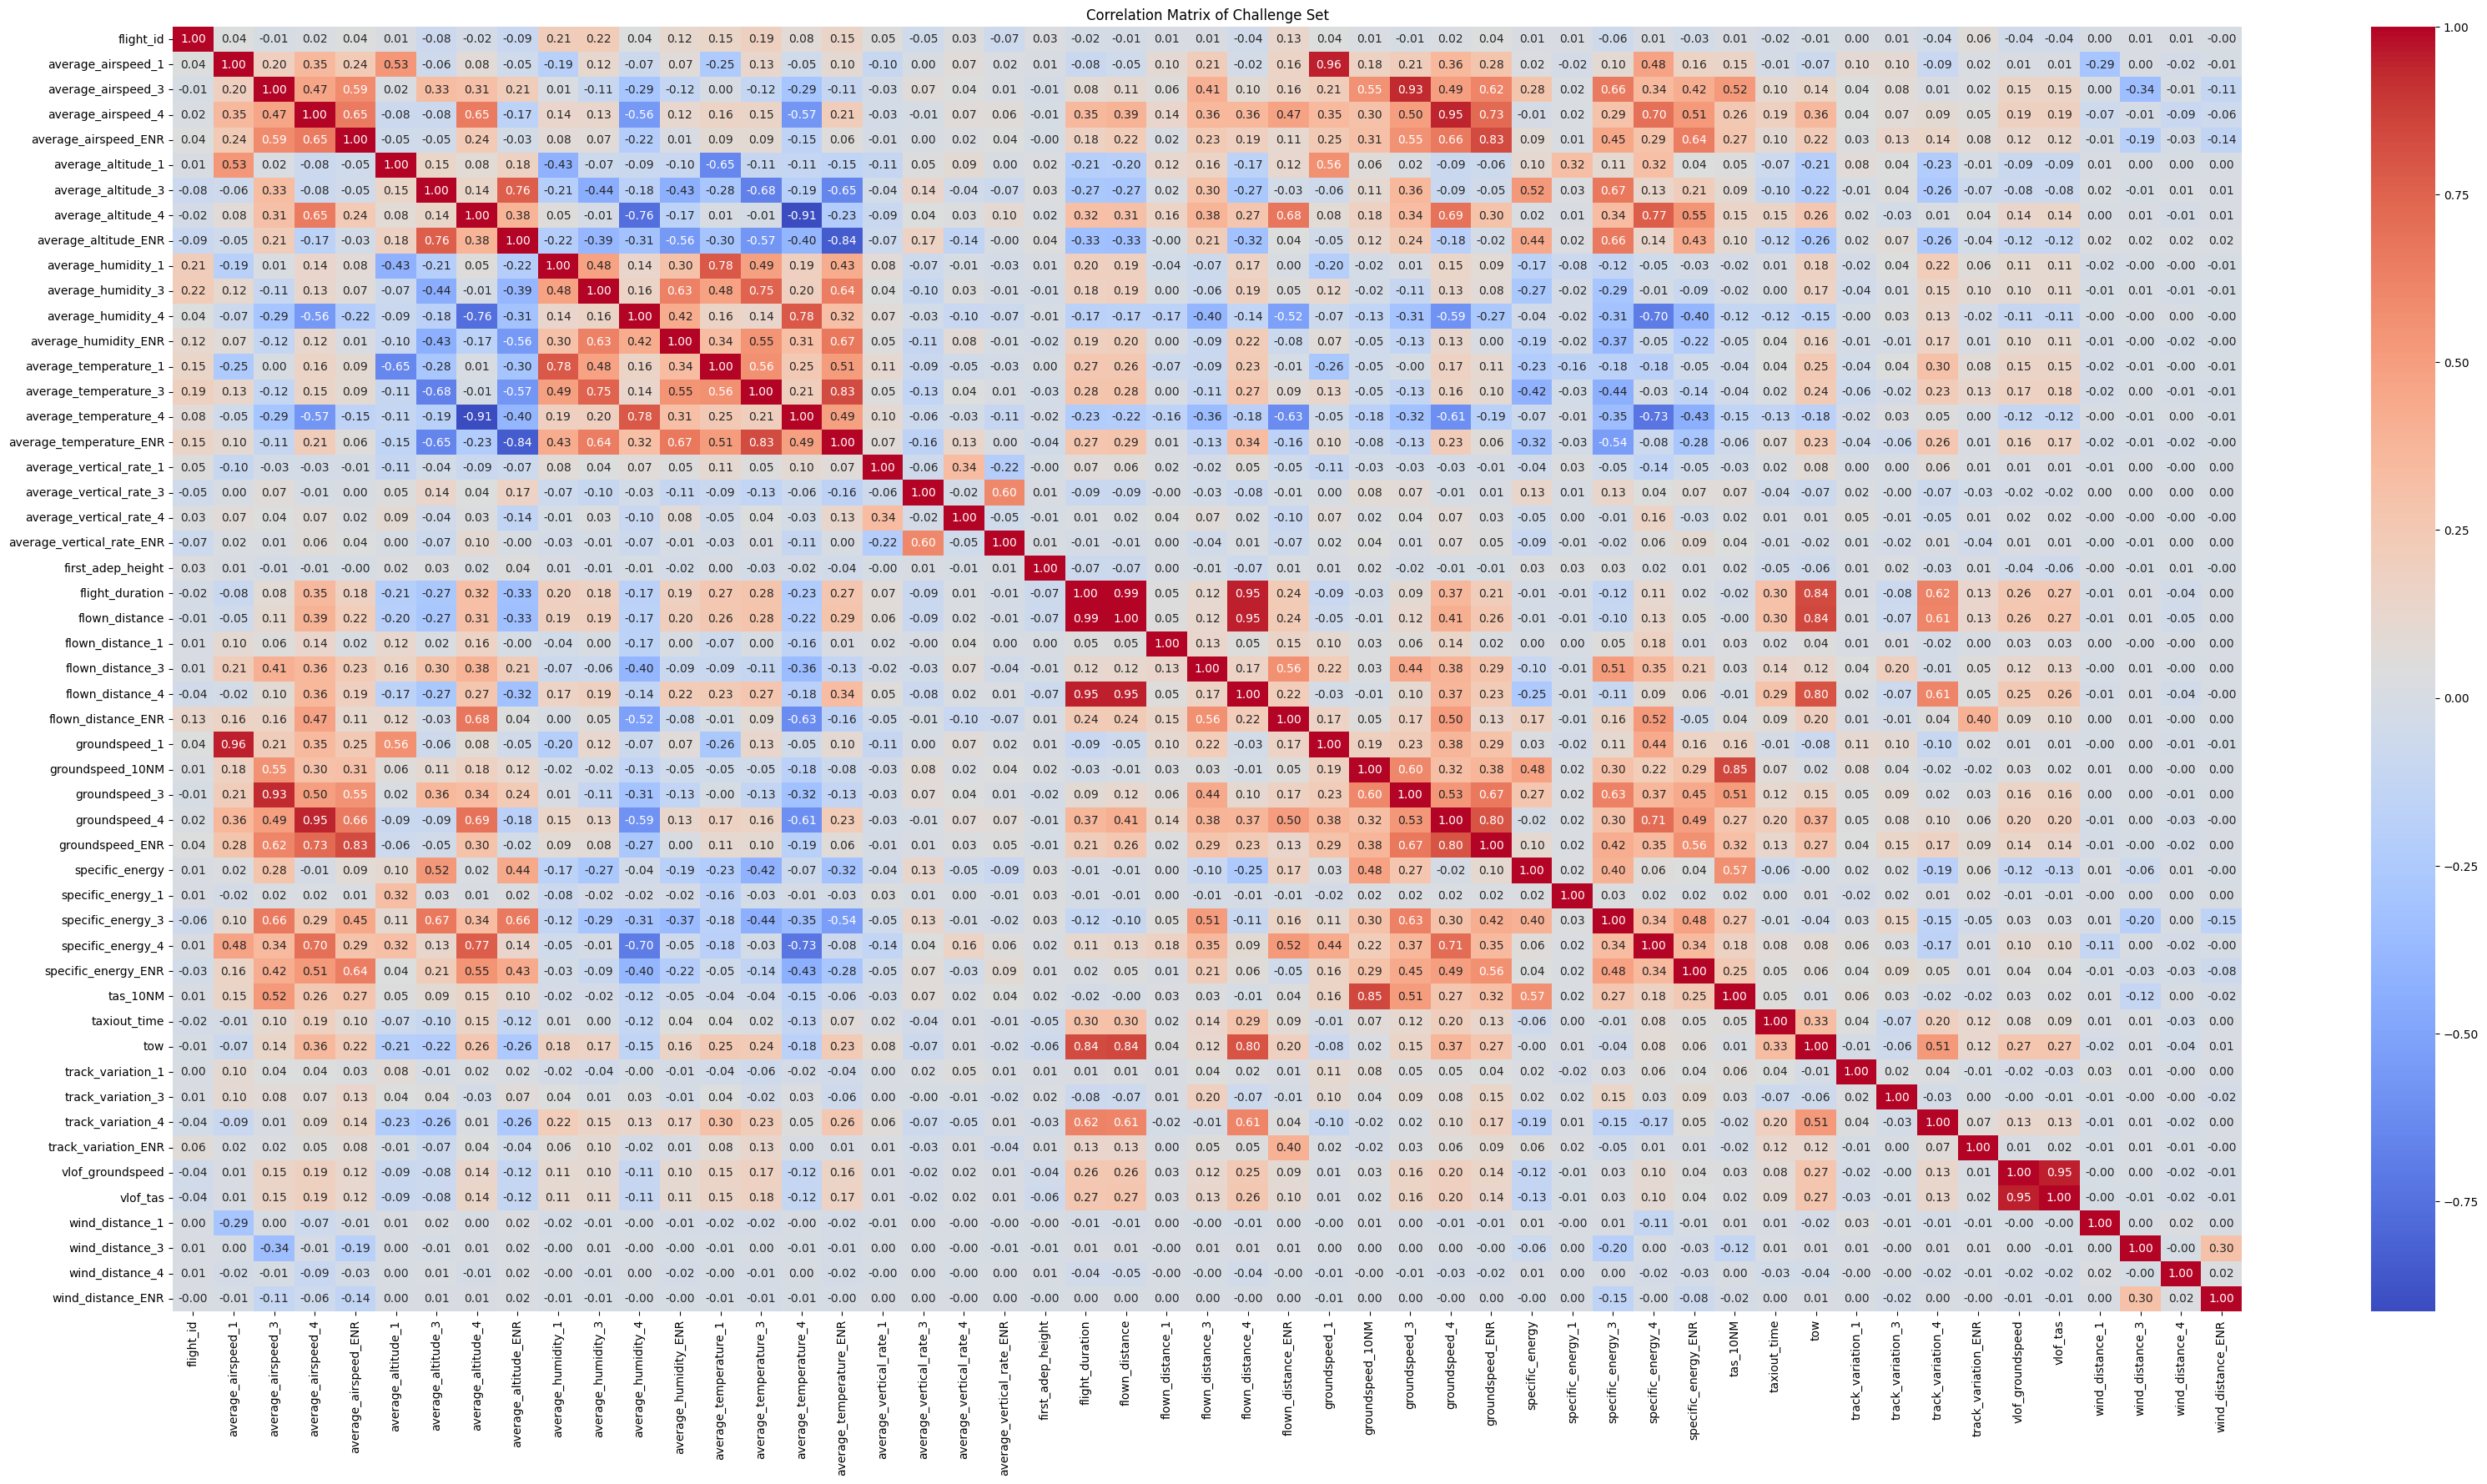

(          flight_id  average_airspeed_1  average_airspeed_3  \
 count  3.690130e+05       345273.000000       341449.000000   
 mean   2.535220e+08          149.236217          155.475871   
 min    2.487506e+08            9.183736          -21.612569   
 25%    2.512296e+08          139.374752          148.278093   
 50%    2.536200e+08          149.550340          156.013098   
 75%    2.559059e+08          160.012522          163.869043   
 max    2.580745e+08          788.247430          621.556408   
 std    2.688565e+06           17.555760           15.105522   
 
        average_airspeed_4  average_airspeed_ENR  average_altitude_1  \
 count       352489.000000         317863.000000       345298.000000   
 mean           222.772013            220.307058        12603.835211   
 min             -7.088778            -25.674828         -335.714286   
 25%            210.480758            207.830727        11018.592818   
 50%            226.139119            220.445772        12619.

In [5]:
# Summary statistics of the challenge set
challenge_summary = challenge_set.describe()

# Check for missing values
missing_values = challenge_set.isnull().sum()

# Drop non-numeric columns before computing the correlation matrix
numeric_challenge_set = challenge_set.select_dtypes(include=['number'])

# Correlation matrix to check relationships between numerical features
correlation_matrix = numeric_challenge_set.corr()

# Plotting the correlation matrix
plt.figure(figsize=(40, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Challenge Set')
plt.show()

# Display the summary statistics and missing values
challenge_summary, missing_values

In [6]:
# Checking for missing values in each column and displaying the result as a DataFrame
missing_values = trajectories_set.isnull().sum()
missing_values_df = pd.DataFrame(missing_values, columns=['Missing Values'])
missing_values_df['Percentage'] = (missing_values_df['Missing Values'] / len(trajectories_set)) * 100
missing_values_df

Missing Values  Percentage
flight_id                                   0    0.000000
date                                        0    0.000000
callsign                                    0    0.000000
adep                                        0    0.000000
name_adep                                   0    0.000000
country_code_adep                           0    0.000000
ades                                        0    0.000000
name_ades                                   0    0.000000
country_code_ades                           0    0.000000
actual_offblock_time                        0    0.000000
arrival_time                                0    0.000000
aircraft_type                               0    0.000000
wtc                                         0    0.000000
airline                                     0    0.000000
flight_duration                             0    0.000000
taxiout_time                                0    0.000000
flown_distance                              0    0.000000
tow                                    105959   22.308473
track_variation_ARR_100                 30216    6.361638
track_variation_DEP_100                 70791   14.904247
track_variation_ENR                     65196   13.726283
average_vertical_rate_ARR_100           30477    6.416589
average_vertical_rate_DEP_100           71355   15.022991
average_vertical_rate_ENR               65200   13.727125
average_airspeed_ARR_100                30806    6.485856
average_airspeed_DEP_100                71440   15.040887
average_airspeed_ENR                    65202   13.727546
groundspeed_ARR_100                     30474    6.415957
groundspeed_DEP_100                     71352   15.022359
groundspeed_ENR                         65198   13.726704
wind_distance_ARR_100                   30216    6.361638
wind_distance_DEP_100                   70791   14.904247
wind_distance_ENR                       65196   13.726283
average_temperature_ARR_100             30598    6.442064
average_temperature_DEP_100             71138   14.977304
average_temperature_ENR                 65200   13.727125
average_humidity_ARR_100                30598    6.442064
average_humidity_DEP_100                71138   14.977304
average_humidity_ENR                    65200   13.727125
specific_energy_ARR_100                197546   41.591083
specific_energy_DEP_100                 72611   15.287427
specific_energy_ENR                     66380   13.975561
flown_distance_ARR_100                  30216    6.361638
flown_distance_DEP_100                  70791   14.904247
flown_distance_ENR                      65196   13.726283
specific_energy                          5678    1.195439

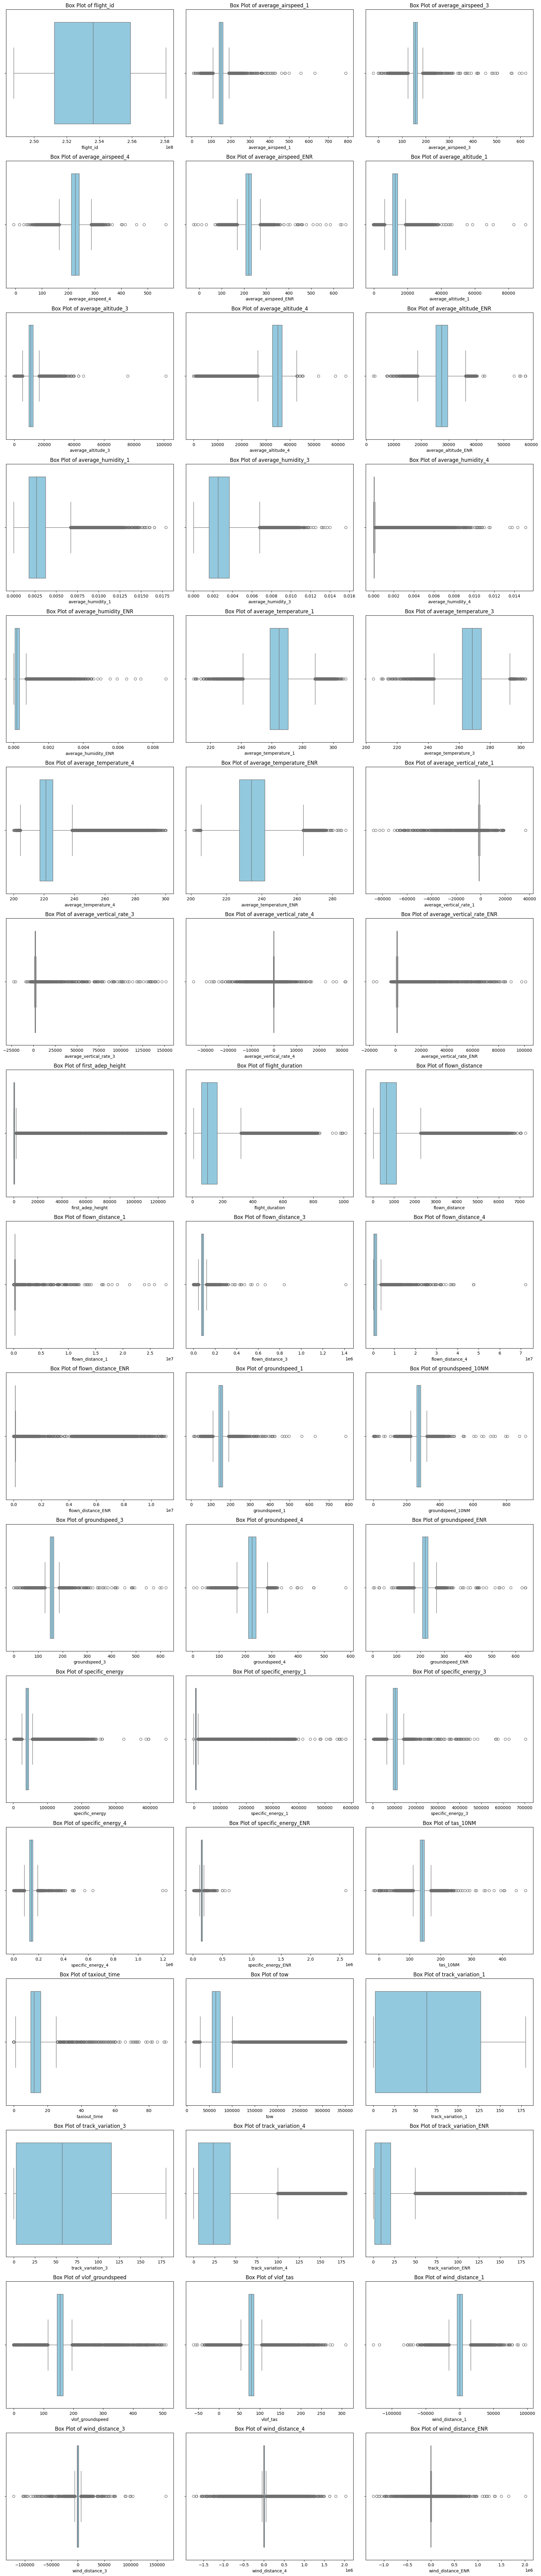

In [7]:
# Extract all numerical columns from the dataset
numerical_columns = challenge_set.select_dtypes(include=['number']).columns

# Set the number of plots per row (3 per row for narrow columns)
plots_per_row = 3
total_plots = len(numerical_columns)
rows = (total_plots + plots_per_row - 1) // plots_per_row  # Calculate the required number of rows

# Set up the figure size, adjusting for the number of rows
plt.figure(figsize=(18, rows * 5))  # Adjust the width and height based on rows

for i, feature in enumerate(numerical_columns, 1):
    plt.subplot(rows, plots_per_row, i)  # Arrange the plots in the grid with three plots per row
    
    # Plotting a boxplot for each numerical feature
    sns.boxplot(x=challenge_set[feature], color='skyblue')
    
    plt.title(f'Box Plot of {feature}')
    plt.xlabel(f'{feature}')
    
plt.tight_layout()
plt.show()

In [8]:
# Check unique countries in the 'adep' and 'ades' columns
adep_countries = challenge_set['country_code_adep'].unique()
ades_countries = challenge_set['country_code_ades'].unique()

# Combine both lists to get a unique set of countries
all_countries = set(adep_countries).union(set(ades_countries))

# Display the unique countries
print("Unique countries in cleaned_challenge_set:")
print(sorted(all_countries))

Unique countries in cleaned_challenge_set:
['##', 'AE', 'AL', 'AM', 'AN', 'AO', 'AT', 'AW', 'AZ', 'BA', 'BB', 'BD', 'BE', 'BG', 'BH', 'BJ', 'BR', 'BY', 'CA', 'CD', 'CG', 'CH', 'CI', 'CR', 'CU', 'CV', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EE', 'EG', 'ES', 'ET', 'FI', 'FR', 'GB', 'GE', 'GH', 'GI', 'GR', 'HR', 'HU', 'ID', 'IE', 'IL', 'IN', 'IQ', 'IR', 'IS', 'IT', 'JM', 'JO', 'JP', 'KG', 'KR', 'KZ', 'LB', 'LC', 'LR', 'LT', 'LU', 'LV', 'MA', 'MD', 'ME', 'MK', 'MN', 'MT', 'MU', 'MX', 'MY', 'NG', 'NL', 'NO', 'NP', 'OM', 'PA', 'PH', 'PK', 'PL', 'PT', 'QA', 'RO', 'RS', 'RU', 'RW', 'SA', 'SD', 'SE', 'SI', 'SK', 'SL', 'SN', 'SO', 'TH', 'TM', 'TN', 'TR', 'TZ', 'UA', 'US', 'UZ', 'VE', 'VN', 'XK', 'ZA']


In [9]:
# Check unique countries in the 'adep' and 'ades' columns
adep_countries = submission_set['country_code_adep'].unique()
ades_countries = submission_set['country_code_ades'].unique()

# Combine both lists to get a unique set of countries
all_countries_sub = set(adep_countries).union(set(ades_countries))

# Display the unique countries
print("Unique countries in cleaned_challenge_set:")
print(sorted(all_countries_sub))

Unique countries in cleaned_challenge_set:
['##', 'AE', 'AL', 'AM', 'AN', 'AT', 'AZ', 'BA', 'BE', 'BG', 'BH', 'BY', 'CA', 'CH', 'CI', 'CR', 'CU', 'CV', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EE', 'EG', 'ER', 'ES', 'FI', 'FR', 'GB', 'GE', 'GR', 'HR', 'HU', 'ID', 'IE', 'IL', 'IN', 'IQ', 'IR', 'IS', 'IT', 'JM', 'JO', 'JP', 'KG', 'KZ', 'LB', 'LC', 'LR', 'LT', 'LU', 'LV', 'MA', 'MD', 'ME', 'MK', 'MN', 'MT', 'MX', 'NL', 'NO', 'OM', 'PA', 'PK', 'PL', 'PT', 'QA', 'RO', 'RS', 'RU', 'SA', 'SE', 'SI', 'SK', 'SL', 'SN', 'TH', 'TM', 'TN', 'TR', 'TZ', 'UA', 'US', 'UZ', 'XK', 'ZA']


In [10]:
set(all_countries_sub) - set(all_countries)

{'ER'}

In [11]:
set(all_countries) - set(all_countries_sub)

{'AO',
 'AW',
 'BB',
 'BD',
 'BJ',
 'BR',
 'CD',
 'CG',
 'ET',
 'GH',
 'GI',
 'KR',
 'MU',
 'MY',
 'NG',
 'NP',
 'PH',
 'RW',
 'SD',
 'SO',
 'VE',
 'VN'}

In [12]:
challenge_set.columns

Index(['flight_id', 'actual_offblock_time', 'adep', 'ades', 'aircraft_type',
       'airline', 'arrival_time', 'average_airspeed_1', 'average_airspeed_3',
       'average_airspeed_4', 'average_airspeed_ENR', 'average_altitude_1',
       'average_altitude_3', 'average_altitude_4', 'average_altitude_ENR',
       'average_humidity_1', 'average_humidity_3', 'average_humidity_4',
       'average_humidity_ENR', 'average_temperature_1',
       'average_temperature_3', 'average_temperature_4',
       'average_temperature_ENR', 'average_vertical_rate_1',
       'average_vertical_rate_3', 'average_vertical_rate_4',
       'average_vertical_rate_ENR', 'callsign', 'country_code_adep',
       'country_code_ades', 'date', 'first_adep_height', 'flight_duration',
       'flown_distance', 'flown_distance_1', 'flown_distance_3',
       'flown_distance_4', 'flown_distance_ENR', 'groundspeed_1',
       'groundspeed_10NM', 'groundspeed_3', 'groundspeed_4', 'groundspeed_ENR',
       'name_adep', 'name_ades'

In [26]:
def extract_time_features(df):
    df = df[df['actual_offblock_time'].notna() & df['arrival_time'].notna()]

    # Convert 'actual_offblock_time' to datetime
    df['actual_offblock_time'] = pd.to_datetime(df['actual_offblock_time'])

    # Extract basic time features
    df.loc[:, 'offblock_hour'] = df['actual_offblock_time'].dt.hour
    df.loc[:, 'offblock_minute'] = df['actual_offblock_time'].dt.minute
    df.loc[:, 'offblock_day_of_week'] = df['actual_offblock_time'].dt.dayofweek

    return df


In [27]:


# Create additional duration-based features
def create_duration_features(df):
    df = df.copy()
    # Replace zero or negative values in flight_duration to avoid division errors
    df.loc[:, 'flight_duration'] = df['flight_duration'].replace(0, np.nan)
    df.loc[:, 'taxiout_time'] = df['taxiout_time'].replace(0, np.nan)
    
    # Fill NaN values in taxiout_time with the median or a reasonable default
    df.loc[:, 'taxiout_time'] = df['taxiout_time'].fillna(df['taxiout_time'].median())
    
    # Calculate the ratio of taxiout time to flight duration with error handling
    df.loc[:, 'taxi_ratio'] = df.apply(lambda row: row['taxiout_time'] / row['flight_duration'] 
                                       if pd.notnull(row['flight_duration']) else np.nan, axis=1)
    
    # Fill NaN values in taxi_ratio with the median of taxi_ratio
    df.loc[:, 'taxi_ratio'] = df['taxi_ratio'].fillna(df['taxi_ratio'].median())
    
    # Calculate the average flight speed (distance per minute) with error handling
    df.loc[:, 'flight_speed'] = df.apply(lambda row: row['flown_distance'] / row['flight_duration'] 
                                         if pd.notnull(row['flown_distance']) and pd.notnull(row['flight_duration']) else np.nan, axis=1)
    
    # Fill NaN values in flight_speed with the median value or a reasonable default
    df.loc[:, 'flight_speed'] = df['flight_speed'].fillna(df['flight_speed'].median())
    
    # Normalize taxi_ratio by the median value to control for large values
    df.loc[:, 'normalized_taxi_ratio'] = df['taxi_ratio'] / df['taxi_ratio'].median()
    
    # Categorical features for flight duration buckets
    df.loc[:, 'flight_duration_category'] = pd.cut(df['flight_duration'], bins=[0, 60, 180, 300, np.inf], 
                                                   labels=['Very Short', 'Short', 'Medium', 'Long'], right=False)
    
    # Speed per distance feature for more detailed analysis
    df.loc[:, 'speed_per_distance'] = df.apply(lambda row: row['flight_speed'] / row['flown_distance'] 
                                               if pd.notnull(row['flight_speed']) and pd.notnull(row['flown_distance']) else np.nan, axis=1)
    
    # Fill NaN values in speed_per_distance with the median value or a reasonable default
    df.loc[:, 'speed_per_distance'] = df['speed_per_distance'].fillna(df['speed_per_distance'].median())
    
    # Cumulative mean of flight speed to capture trends over time (if data is ordered by time)
    df.loc[:, 'cumulative_avg_speed'] = df['flight_speed'].expanding().mean()
    
    # Handle edge cases and set up conditions for further analysis
    df.loc[:, 'taxi_ratio'] = df['taxi_ratio'].replace([np.inf, -np.inf], np.nan)
    df.loc[:, 'flight_speed'] = df['flight_speed'].replace([np.inf, -np.inf], np.nan)
    
    return df

# Group airports by region based on country codes
def group_airports_by_region(df):
    df = df.copy()
    # Define country groups for regions
    europe_countries = ['GB', 'FR', 'DE', 'ES', 'IT', 'SE', 'CH', 'NL', 'AT', 'IE', 'BE', 'DK', 'FI', 'GR', 'HU', 
                        'IS', 'LT', 'LU', 'LV', 'MT', 'NO', 'PL', 'PT', 'RO', 'SI', 'SK', 'CZ', 'EE', 'BG', 'CY']
    north_america_countries = ['US', 'CA', 'MX']
    south_america_countries = ['BR', 'AR', 'CL', 'CO', 'PE', 'VE', 'UY', 'PY', 'BO', 'EC', 'GY', 'SR']
    middle_east_countries = ['AE', 'SA', 'IL', 'IR', 'IQ', 'JO', 'KW', 'OM', 'QA', 'BH', 'LB', 'SY', 'YE']
    asia_countries = ['JP', 'CN', 'KR', 'IN', 'PK', 'BD', 'VN', 'PH', 'TH', 'MY', 'ID', 'SG', 'MN', 'KZ', 'TM', 'UZ', 'KG']
    africa_countries = ['ZA', 'NG', 'EG', 'DZ', 'MA', 'KE', 'TZ', 'GH', 'ET', 'CI', 'SN', 'SD', 'AO', 'LR', 'RW', 'ER']
    other_countries = set(df['country_code_adep'].unique()).union(set(df['country_code_ades'].unique())) - set(
        europe_countries + north_america_countries + south_america_countries + middle_east_countries + asia_countries + africa_countries)

    # Apply region categorization based on country codes
    def categorize_region(code):
        if code in europe_countries:
            return 'Europe'
        elif code in north_america_countries:
            return 'North America'
        elif code in south_america_countries:
            return 'South America'
        elif code in middle_east_countries:
            return 'Middle East'
        elif code in asia_countries:
            return 'Asia'
        elif code in africa_countries:
            return 'Africa'
        elif code in other_countries:
            return 'Other'
        else:
            return 'Unknown'

    # Apply region classification for adep and ades
    df.loc[:, 'adep_region'] = df['country_code_adep'].apply(categorize_region)
    df.loc[:, 'ades_region'] = df['country_code_ades'].apply(categorize_region)

    return df

# Extract country-related features
def extract_country_features(df):
    df = df.copy()
    # Basic feature indicating if the flight is within the same country
    df.loc[:, 'same_country_flight'] = (df['country_code_adep'] == df['country_code_ades']).astype(int)

    # Feature indicating if the flight is within the same region
    df.loc[:, 'same_region_flight'] = (df['adep_region'] == df['ades_region']).astype(int)

    # Flight direction based on regions: North-South, East-West, or Other
    df.loc[:, 'flight_direction'] = df.apply(
        lambda row: 'North-South' if row['adep_region'] in ['North America', 'Europe'] and row['ades_region'] in ['South America', 'Africa']
        else 'East-West' if row['adep_region'] in ['Europe', 'Asia'] and row['ades_region'] in ['North America']
        else 'Other', axis=1)

    # Create a feature indicating if the flight is intercontinental
    intercontinental_regions = ['Europe', 'North America', 'South America', 'Middle East', 'Asia', 'Africa']
    df.loc[:, 'is_intercontinental'] = df.apply(
        lambda row: 1 if row['adep_region'] in intercontinental_regions and 
                         row['ades_region'] in intercontinental_regions and 
                         row['adep_region'] != row['ades_region'] else 0, axis=1)
    return df

def create_interactions(df):
    df = df.copy()
    # Create interaction features between airspeed and specific energy for different flight phases
    df.loc[:, 'airspeed_specific_energy_ARR'] = df['average_airspeed_1'] * df['specific_energy_1']
    df.loc[:, 'airspeed_specific_energy_DEP'] = df['average_airspeed_3'] * df['specific_energy_3']
    df.loc[:, 'airspeed_specific_energy_ENR'] = df['average_airspeed_ENR'] * df['specific_energy_ENR']
    return df

def create_bins(df):
    df = df.copy()
    # Create bins (discretization) for temperature and humidity into 5 categories
    df.loc[:, 'temperature_bins_ARR'] = pd.cut(df['average_temperature_1'], bins=5, labels=False)
    df.loc[:, 'humidity_bins_DEP'] = pd.cut(df['average_humidity_3'], bins=5, labels=False)
    return df

def create_ratios(df):
    df = df.copy()
    # Create ratio features such as vertical rate to airspeed for arrival and departure phases
    df.loc[:, 'vertical_rate_airspeed_ratio_ARR'] = df['average_vertical_rate_1'] / df['average_airspeed_1']
    df.loc[:, 'vertical_rate_airspeed_ratio_DEP'] = df['average_vertical_rate_3'] / df['average_airspeed_3']
    return df

# Function to remove original columns after feature extraction
def remove_columns(df, columns_to_remove):
    # Remove original columns since features have been extracted
    df = df.drop(columns_to_remove, axis=1)
    return df

# List of columns to remove after feature extraction
columns_to_remove = ['name_adep', 'name_ades', 'country_code_adep', 'country_code_ades', 'flight_id', 'callsign', 
                     'actual_offblock_time', 'arrival_time', 'flight_duration']

# Apply all functions to the challenge set
challenge_set = challenge_set.copy()
cleaned_challenge_set = extract_time_features(challenge_set)
print("extract_time_features completed")

cleaned_challenge_set = create_duration_features(cleaned_challenge_set)
print("create_duration_features completed")

cleaned_challenge_set = group_airports_by_region(cleaned_challenge_set)
print("group_airports_by_region completed")

cleaned_challenge_set = extract_country_features(cleaned_challenge_set)
print("extract_country_features completed")

cleaned_challenge_set = create_interactions(cleaned_challenge_set)
print("create_interactions completed")

cleaned_challenge_set = create_bins(cleaned_challenge_set)
print("create_bins completed")

cleaned_challenge_set = create_ratios(cleaned_challenge_set)
print("create_ratios completed")

cleaned_challenge_set = remove_columns(cleaned_challenge_set, columns_to_remove)
print("remove_columns completed")

# Apply all functions to the submission set
submission_set = submission_set.copy()
cleaned_submission_set = extract_time_features(submission_set)
print("extract_time_features completed on submission_set")

cleaned_submission_set = create_duration_features(cleaned_submission_set)
print("create_duration_features completed on submission_set")

cleaned_submission_set = group_airports_by_region(cleaned_submission_set)
print("group_airports_by_region completed on submission_set")

cleaned_submission_set = extract_country_features(cleaned_submission_set)
print("extract_country_features completed on submission_set")

cleaned_submission_set = create_interactions(cleaned_submission_set)
print("create_interactions completed on submission_set")

cleaned_submission_set = create_bins(cleaned_submission_set)
print("create_bins completed on submission_set")

cleaned_submission_set = create_ratios(cleaned_submission_set)
print("create_ratios completed on submission_set")

cleaned_submission_set = remove_columns(cleaned_submission_set, columns_to_remove)
print("remove_columns completed on submission_set")

# Display the transposed first few rows of the updated challenge set for review
cleaned_challenge_set.head().T

extract_time_features completed


/tmp/ipykernel_144097/2831348898.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[18. 13. 15. ... 11. 12. 16.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, 'taxiout_time'] = df['taxiout_time'].replace(0, np.nan)


create_duration_features completed
group_airports_by_region completed
extract_country_features completed
create_interactions completed
create_bins completed
create_ratios completed
remove_columns completed
extract_time_features completed on submission_set


/tmp/ipykernel_144097/2831348898.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[15. 15. 10. ... 25.  9. 10.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, 'taxiout_time'] = df['taxiout_time'].replace(0, np.nan)


create_duration_features completed on submission_set
group_airports_by_region completed on submission_set
extract_country_features completed on submission_set
create_interactions completed on submission_set
create_bins completed on submission_set
create_ratios completed on submission_set
remove_columns completed on submission_set


0  \
adep                                                          EGLL   
ades                                                          EICK   
aircraft_type                                                 A320   
airline                           a73f82288988b79be490c6322f4c32ed   
average_airspeed_1                                      144.185879   
...                                                            ...   
airspeed_specific_energy_ENR                       26077832.490486   
temperature_bins_ARR                                           2.0   
humidity_bins_DEP                                              1.0   
vertical_rate_airspeed_ratio_ARR                         -8.956824   
vertical_rate_airspeed_ratio_DEP                         11.810575   

                                                                 1  \
adep                                                          LEBL   
ades                                                          KMIA   
aircraft_type                                                 B772   
airline                           5543e4dc327359ffaf5b9c0e6faaf0e1   
average_airspeed_1                                      110.541874   
...                                                            ...   
airspeed_specific_energy_ENR                       34963913.021454   
temperature_bins_ARR                                           4.0   
humidity_bins_DEP                                              0.0   
vertical_rate_airspeed_ratio_ARR                         -7.702158   
vertical_rate_airspeed_ratio_DEP                         12.305934   

                                                                 2  \
adep                                                          ESSA   
ades                                                          KORD   
aircraft_type                                                 A333   
airline                           8be5c854fd664bcb97fb543339f74770   
average_airspeed_1                                      133.077865   
...                                                            ...   
airspeed_specific_energy_ENR                       26330074.632605   
temperature_bins_ARR                                           2.0   
humidity_bins_DEP                                              0.0   
vertical_rate_airspeed_ratio_ARR                          -6.07857   
vertical_rate_airspeed_ratio_DEP                         12.968252   

                                                                 3  \
adep                                                          LSZH   
ades                                                          KPHL   
aircraft_type                                                 B788   
airline                           5543e4dc327359ffaf5b9c0e6faaf0e1   
average_airspeed_1                                      133.830908   
...                                                            ...   
airspeed_specific_energy_ENR                       39786664.947421   
temperature_bins_ARR                                           3.0   
humidity_bins_DEP                                              0.0   
vertical_rate_airspeed_ratio_ARR                         -5.164809   
vertical_rate_airspeed_ratio_DEP                         13.949519   

                                                                 4  
adep                                                          EIDW  
ades                                                          EGLL  
aircraft_type                                                 A21N  
airline                           a73f82288988b79be490c6322f4c32ed  
average_airspeed_1                                      128.935202  
...                                                            ...  
airspeed_specific_energy_ENR                       49920987.812264  
temperature_bins_ARR                                           2.0  
humidity_bins_DEP                                              0.0  
vertical_ra

In [29]:
# Extracting unique aircraft types from each set
challenge_aircraft_types = set(challenge_set['aircraft_type'].unique())
submission_aircraft_types = set(submission_set['aircraft_type'].unique())

# Aircraft types in challenge_set but not in submission_set
only_in_challenge = challenge_aircraft_types - submission_aircraft_types
print("Aircraft types only in challenge_set:", only_in_challenge)

# Aircraft types in submission_set but not in challenge_set
only_in_submission = submission_aircraft_types - challenge_aircraft_types
print("Aircraft types only in submission_set:", only_in_submission)

Aircraft types only in challenge_set: {'C56X', 'A310'}
Aircraft types only in submission_set: set()


In [30]:
!pip install openpyxl

# Load the FAA Aircraft Characteristics Database from the uploaded Excel file
file_path = "./extra_data/FAA-Aircraft-Char-DB-AC-150-5300-13B-App-2023-09-07.xlsx"

# Load the FAA dataset and select relevant columns
faa_data = pd.read_excel(file_path, sheet_name='ACD_Data')

# Select relevant columns for merging
# faa_relevant_columns = [
#     'FAA_Designator', 'Manufacturer', 'Model_FAA', 'Physical_Class_Engine', 'Num_Engines', 'ADG', 'TDG', 'Approach_Speed_knot', 'MTOW_lb', 
#     'Wingspan_ft_without_winglets_sharklets', 'Length_ft', 'Tail_Height_at_OEW_ft', 'Wheelbase_ft', 'Cockpit_to_Main_Gear_ft', 'Main_Gear_Width_ft', 
#     'MALW_lb', 'Main_Gear_Config', 'Parking_Area_ft2', 'Class', 'FAA_Weight', 'CWT', 'One_Half_Wake_Category', 'Two_Wake_Category_Appx_A', 
#     'Two_Wake_Category_Appx_B', 'Rotor_Diameter_ft', 'SRS', 'Registration_Count', 'Total_IFR_Operations_2021_2022']

faa_relevant_columns = [
    'FAA_Designator',
    'Physical_Class_Engine',
    'Num_Engines',
    'Approach_Speed_knot',
    'Wingspan_ft_without_winglets_sharklets',
    'Wingspan_ft_with_winglets_sharklets',
    'Length_ft',
    'Tail_Height_at_OEW_ft',
    'Wheelbase_ft',
    'Cockpit_to_Main_Gear_ft',
    'Main_Gear_Width_ft',
    'MTOW_lb',
    'MALW_lb',
    'Main_Gear_Config',
    'Parking_Area_ft2',
    'FAA_Weight',
    'Total_IFR_Operations_2021_2022'
]

# Prepare the FAA data for merging
faa_clean = faa_data[faa_relevant_columns].copy()  # Use .copy() to avoid the warning

# Convert MTOW and MALW from pounds to kilograms for consistency
faa_clean.loc[:, 'MTOW_kg'] = faa_clean['MTOW_lb'] * 0.453592
faa_clean.loc[:, 'MALW_kg'] = faa_clean['MALW_lb'] * 0.453592

# Merge the cleaned_challenge_set with FAA data on aircraft_type and FAA_Designator
cleaned_challenge_set = cleaned_challenge_set.merge(
    faa_clean, how='left', left_on='aircraft_type', right_on='FAA_Designator'
)

# Merge the cleaned_submission_set with FAA data on aircraft_type and FAA_Designator
cleaned_submission_set = cleaned_submission_set.merge(
    faa_clean, how='left', left_on='aircraft_type', right_on='FAA_Designator'
)

# Drop unnecessary columns
cleaned_challenge_set.drop(["FAA_Designator", "MTOW_lb", "MALW_lb"], axis=1, inplace=True)
cleaned_submission_set.drop(["FAA_Designator", "MTOW_lb", "MALW_lb"], axis=1, inplace=True)

# Display the transposed cleaned_challenge_set for review
cleaned_challenge_set.T

Defaulting to user installation because normal site-packages is not writeable


0       \
adep                                                        EGLL   
ades                                                        EICK   
aircraft_type                                               A320   
airline                         a73f82288988b79be490c6322f4c32ed   
average_airspeed_1                                    144.185879   
...                                                          ...   
Parking_Area_ft2                                         16354.4   
FAA_Weight                                                 Large   
Total_IFR_Operations_2021_2022                           2765265   
MTOW_kg                                             78000.133912   
MALW_kg                                              65999.90396   

                                                          1       \
adep                                                        LEBL   
ades                                                        KMIA   
aircraft_type                                               B772   
airline                         5543e4dc327359ffaf5b9c0e6faaf0e1   
average_airspeed_1                                    110.541874   
...                                                          ...   
Parking_Area_ft2                                         44939.7   
FAA_Weight                                                 Heavy   
Total_IFR_Operations_2021_2022                            222264   
MTOW_kg                                               297556.352   
MALW_kg                                                213188.24   

                                                          2       \
adep                                                        ESSA   
ades                                                        KORD   
aircraft_type                                               A333   
airline                         8be5c854fd664bcb97fb543339f74770   
average_airspeed_1                                    133.077865   
...                                                          ...   
Parking_Area_ft2                                         44473.5   
FAA_Weight                                                 Heavy   
Total_IFR_Operations_2021_2022                            206739   
MTOW_kg                                            241999.950248   
MALW_kg                                            186999.652288   

                                                          3       \
adep                                                        LSZH   
ades                                                        KPHL   
aircraft_type                                               B788   
airline                         5543e4dc327359ffaf5b9c0e6faaf0e1   
average_airspeed_1                                    133.830908   
...                                                          ...   
Parking_Area_ft2                                         39602.0   
FAA_Weight                                                 Heavy   
Total_IFR_Operations_2021_2022                            208774   
MTOW_kg                                                227929.98   
MALW_kg                                                172364.96   

                                                          4       \
adep                                                        EIDW   
ades                                                        EGLL   
aircraft_type                                               A21N   
airline                         a73f82288988b79be490c6322f4c32ed   
average_airspeed_1                                    128.935202   
...                                                          ...   
Parking_Area_ft2                                         19253.0   
FAA_Weight                                                 Large   
Total_IFR_Operations_2021_2022                            490022   
MTOW_kg                                             94999.854888   
MALW_kg                                   

In [31]:
list(cleaned_challenge_set.columns)

['adep',
 'ades',
 'aircraft_type',
 'airline',
 'average_airspeed_1',
 'average_airspeed_3',
 'average_airspeed_4',
 'average_airspeed_ENR',
 'average_altitude_1',
 'average_altitude_3',
 'average_altitude_4',
 'average_altitude_ENR',
 'average_humidity_1',
 'average_humidity_3',
 'average_humidity_4',
 'average_humidity_ENR',
 'average_temperature_1',
 'average_temperature_3',
 'average_temperature_4',
 'average_temperature_ENR',
 'average_vertical_rate_1',
 'average_vertical_rate_3',
 'average_vertical_rate_4',
 'average_vertical_rate_ENR',
 'date',
 'first_adep_height',
 'flown_distance',
 'flown_distance_1',
 'flown_distance_3',
 'flown_distance_4',
 'flown_distance_ENR',
 'groundspeed_1',
 'groundspeed_10NM',
 'groundspeed_3',
 'groundspeed_4',
 'groundspeed_ENR',
 'specific_energy',
 'specific_energy_1',
 'specific_energy_3',
 'specific_energy_4',
 'specific_energy_ENR',
 'tas_10NM',
 'taxiout_time',
 'tow',
 'track_variation_1',
 'track_variation_3',
 'track_variation_4',
 'tra

In [32]:
# Check for unique aircraft types in the cleaned challenge set
unique_aircraft_types = cleaned_challenge_set['aircraft_type'].unique()

# Check which aircraft types from the challenge set are not present in the FAA data
missing_aircraft_types = [atype for atype in unique_aircraft_types if atype not in faa_data['FAA_Designator'].unique()]

missing_aircraft_types

[]

In [33]:
# Load the GlobalAirportDatabase.txt into a DataFrame
columns_global = ['ICAO', 'IATA', 'Airport Name', 'City/Town', 'Country', 
                  'Latitude Degrees', 'Latitude Minutes', 'Latitude Seconds', 'Latitude Direction',
                  'Longitude Degrees', 'Longitude Minutes', 'Longitude Seconds', 'Longitude Direction',
                  'Altitude', 'Latitude Decimal Degrees', 'Longitude Decimal Degrees']
global_airports = pd.read_csv('./extra_data/GlobalAirportDatabase.txt', sep=':', header=None, names=columns_global)

# Select relevant columns including Altitude (ICAO, Latitude Decimal Degrees, Longitude Decimal Degrees, Altitude)
global_airports = global_airports[['ICAO', 'Latitude Decimal Degrees', 'Longitude Decimal Degrees', 'Altitude']]

# Load the airports.dat file (assuming previous naming and structure)
columns_openflights = ['Airport ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 
                       'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST', 'Tz database time zone', 
                       'Type', 'Source']
openflights_airports = pd.read_csv('./extra_data/airports.dat', header=None, names=columns_openflights)

# Select relevant columns including Altitude (ICAO, Latitude Decimal Degrees, Longitude Decimal Degrees, Altitude)
openflights_airports = openflights_airports[['ICAO', 'Latitude', 'Longitude', 'Altitude']]
openflights_airports.rename(columns={'Latitude': 'Latitude Decimal Degrees', 
                                     'Longitude': 'Longitude Decimal Degrees'}, inplace=True)

# Concatenate both datasets, removing duplicates based on ICAO codes
airports = pd.concat([global_airports, openflights_airports]).drop_duplicates(subset=['ICAO'])

# Display the combined dataset to verify the merge
airports.head()

ICAO  Latitude Decimal Degrees  Longitude Decimal Degrees  Altitude
0  AYGA                    -6.082                    145.392      1610
1  AYLA                     0.000                      0.000         0
2  AYMD                    -5.207                    145.789         7
3  AYMH                    -5.826                    144.296      1643
4  AYNZ                    -6.570                    146.726        73

In [34]:
# Backup
backup_challenge_set = cleaned_challenge_set.copy()

# Merge airports data to cleaned_challenge_set for both departure (adep) and arrival (ades) airports

# Merge for adep (departure airport)
cleaned_challenge_set = pd.merge(
    cleaned_challenge_set, airports, 
    how='left', left_on='adep', right_on='ICAO', 
    suffixes=('_adep', '')
)

# Rename latitude, longitude, and altitude columns for adep correctly
cleaned_challenge_set.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_adep', 
        'Longitude Decimal Degrees': 'Longitude_adep',
        'Altitude': 'Altitude_adep'
    }, 
    inplace=True
)

# Merge for ades (arrival airport)
cleaned_challenge_set = pd.merge(
    cleaned_challenge_set, airports, 
    how='left', left_on='ades', right_on='ICAO', 
    suffixes=('', '_ades')
)

# Rename latitude, longitude, and altitude columns for ades correctly
cleaned_challenge_set.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_ades', 
        'Longitude Decimal Degrees': 'Longitude_ades',
        'Altitude': 'Altitude_ades'
    }, 
    inplace=True
)

# Display the transposed DataFrame to confirm the correct columns are retained
cleaned_challenge_set.T

0       \
adep                                            EGLL   
ades                                            EICK   
aircraft_type                                   A320   
airline             a73f82288988b79be490c6322f4c32ed   
average_airspeed_1                        144.185879   
...                                              ...   
Altitude_adep                                   25.0   
ICAO_ades                                       EICK   
Latitude_ades                                 51.843   
Longitude_ades                                -8.492   
Altitude_ades                                  154.0   

                                              1       \
adep                                            LEBL   
ades                                            KMIA   
aircraft_type                                   B772   
airline             5543e4dc327359ffaf5b9c0e6faaf0e1   
average_airspeed_1                        110.541874   
...                                              ...   
Altitude_adep                                    4.0   
ICAO_ades                                       KMIA   
Latitude_ades                                 25.793   
Longitude_ades                               -80.291   
Altitude_ades                                    3.0   

                                              2       \
adep                                            ESSA   
ades                                            KORD   
aircraft_type                                   A333   
airline             8be5c854fd664bcb97fb543339f74770   
average_airspeed_1                        133.077865   
...                                              ...   
Altitude_adep                                   38.0   
ICAO_ades                                       KORD   
Latitude_ades                                 41.979   
Longitude_ades                               -87.904   
Altitude_ades                                  204.0   

                                              3       \
adep                                            LSZH   
ades                                            KPHL   
aircraft_type                                   B788   
airline             5543e4dc327359ffaf5b9c0e6faaf0e1   
average_airspeed_1                        133.830908   
...                                              ...   
Altitude_adep                                  432.0   
ICAO_ades                                       KPHL   
Latitude_ades                                 39.872   
Longitude_ades                               -75.241   
Altitude_ades                                   12.0   

                                              4       \
adep                                            EIDW   
ades                                            EGLL   
aircraft_type                                   A21N   
airline             a73f82288988b79be490c6322f4c32ed   
average_airspeed_1                        128.935202   
...                                              ...   
Altitude_adep                                   74.0   
ICAO_ades                                       EGLL   
Latitude_ades                                 51.477   
Longitude_ades                                -0.461   
Altitude_ades                                   25.0   

                                              5       \
adep                                            ENGM   
ades                                            LEAL   
aircraft_type                                   A20N   
airline             8be5c854fd664bcb97fb543339f74770   
average_airspeed_1                        154.322763   
...                                              ...   
Altitude_adep                                  208.0   
ICAO_ades                                       LEAL   
Latitude_ades                                 38.282   
Longitude_ades                                -0.558   
Altitude_ades                                   44.0   

        

In [35]:
# Count missing values for each column in the cleaned_challenge_set DataFrame
missing_values = cleaned_challenge_set.isnull().sum()

# Identify columns with missing values
columns_with_missing = missing_values[missing_values > 0]

# Specifically count the unique missing ICAO codes by examining columns related to ICAO information
# Assuming 'adep' and 'ades' are the columns where ICAO codes are merged
missing_icaos_adep = cleaned_challenge_set[cleaned_challenge_set['Latitude_adep'].isnull()]['adep'].unique()
missing_icaos_ades = cleaned_challenge_set[cleaned_challenge_set['Latitude_ades'].isnull()]['ades'].unique()

# Combine both lists to find unique ICAO codes missing in both 'adep' and 'ades'
unique_missing_icaos = set(missing_icaos_adep).union(set(missing_icaos_ades))

# Count the number of unique ICAO codes missing
unique_missing_count = len(unique_missing_icaos)

unique_missing_count, unique_missing_icaos

(9, {'HSSK', 'LFTM', 'LTFG', 'LTFO', 'UCFM', 'UTFF', 'VGHS', 'VOGO', 'ZMCK'})

In [36]:
# Display rows in the DataFrame that have missing values in any column
rows_with_missing_values = cleaned_challenge_set[cleaned_challenge_set.isnull().any(axis=1)]

# Display the rows with missing values
rows_with_missing_values.T

1       \
adep                                            LEBL   
ades                                            KMIA   
aircraft_type                                   B772   
airline             5543e4dc327359ffaf5b9c0e6faaf0e1   
average_airspeed_1                        110.541874   
...                                              ...   
Altitude_adep                                    4.0   
ICAO_ades                                       KMIA   
Latitude_ades                                 25.793   
Longitude_ades                               -80.291   
Altitude_ades                                    3.0   

                                              2       \
adep                                            ESSA   
ades                                            KORD   
aircraft_type                                   A333   
airline             8be5c854fd664bcb97fb543339f74770   
average_airspeed_1                        133.077865   
...                                              ...   
Altitude_adep                                   38.0   
ICAO_ades                                       KORD   
Latitude_ades                                 41.979   
Longitude_ades                               -87.904   
Altitude_ades                                  204.0   

                                              3       \
adep                                            LSZH   
ades                                            KPHL   
aircraft_type                                   B788   
airline             5543e4dc327359ffaf5b9c0e6faaf0e1   
average_airspeed_1                        133.830908   
...                                              ...   
Altitude_adep                                  432.0   
ICAO_ades                                       KPHL   
Latitude_ades                                 39.872   
Longitude_ades                               -75.241   
Altitude_ades                                   12.0   

                                              4       \
adep                                            EIDW   
ades                                            EGLL   
aircraft_type                                   A21N   
airline             a73f82288988b79be490c6322f4c32ed   
average_airspeed_1                        128.935202   
...                                              ...   
Altitude_adep                                   74.0   
ICAO_ades                                       EGLL   
Latitude_ades                                 51.477   
Longitude_ades                                -0.461   
Altitude_ades                                   25.0   

                                              5       \
adep                                            ENGM   
ades                                            LEAL   
aircraft_type                                   A20N   
airline             8be5c854fd664bcb97fb543339f74770   
average_airspeed_1                        154.322763   
...                                              ...   
Altitude_adep                                  208.0   
ICAO_ades                                       LEAL   
Latitude_ades                                 38.282   
Longitude_ades                                -0.558   
Altitude_ades                                   44.0   

                                              8       \
adep                                            KLAX   
ades                                            LTFM   
aircraft_type                                   B789   
airline             6351ec1b849adacc0cbb3b1313d8d39b   
average_airspeed_1                         336.21411   
...                                              ...   
Altitude_adep                                   39.0   
ICAO_ades                                       LTFM   
Latitude_ades                              41.275278   
Longitude_ades                             28.751944   
Altitude_ades                                  325.0   

        

In [37]:
# Applying the same transformations for submission_set as described for challenge_set

# Backup
backup_submission_set = cleaned_submission_set.copy()

# Filter updated_airports to include only ICAO codes present in cleaned_submission_set (adep and ades)
relevant_icaos_submission = cleaned_submission_set['adep'].unique().tolist() + cleaned_submission_set['ades'].unique().tolist()
filtered_airports_submission = airports[airports['ICAO'].isin(relevant_icaos_submission)]

# Merge airports data to submission_set for both departure (adep) and arrival (ades) airports
# Merge for adep (departure airport)
cleaned_submission_set = pd.merge(
    cleaned_submission_set, filtered_airports_submission, 
    how='left', left_on='adep', right_on='ICAO', 
    suffixes=('_adep', '')
)

# Rename latitude, longitude, and altitude columns for adep correctly
cleaned_submission_set.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_adep', 
        'Longitude Decimal Degrees': 'Longitude_adep',
        'Altitude': 'Altitude_adep'
    }, 
    inplace=True
)

# Merge for ades (arrival airport)
cleaned_submission_set = pd.merge(
    cleaned_submission_set, filtered_airports_submission, 
    how='left', left_on='ades', right_on='ICAO', 
    suffixes=('', '_ades')
)

# Rename latitude, longitude, and altitude columns for ades correctly
cleaned_submission_set.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_ades', 
        'Longitude Decimal Degrees': 'Longitude_ades',
        'Altitude': 'Altitude_ades'
    }, 
    inplace=True
)

cleaned_submission_set.T

0       \
adep                                            LTFJ   
ades                                            LFLL   
aircraft_type                                   B738   
airline             6351ec1b849adacc0cbb3b1313d8d39b   
average_airspeed_1                        149.209938   
...                                              ...   
Altitude_adep                                  312.0   
ICAO_ades                                       LFLL   
Latitude_ades                                 45.726   
Longitude_ades                                 5.091   
Altitude_ades                                  251.0   

                                              1       \
adep                                            EBBR   
ades                                            KJFK   
aircraft_type                                   A333   
airline             bdeeef3a675587d530de70a25d7118d2   
average_airspeed_1                        117.456621   
...                                              ...   
Altitude_adep                                   57.0   
ICAO_ades                                       KJFK   
Latitude_ades                                  40.64   
Longitude_ades                               -73.779   
Altitude_ades                                    4.0   

                                              2       \
adep                                            KMIA   
ades                                            EGLL   
aircraft_type                                   B77W   
airline             5543e4dc327359ffaf5b9c0e6faaf0e1   
average_airspeed_1                        158.649882   
...                                              ...   
Altitude_adep                                    3.0   
ICAO_ades                                       EGLL   
Latitude_ades                                 51.477   
Longitude_ades                                -0.461   
Altitude_ades                                   25.0   

                                              3       \
adep                                            EGCN   
ades                                            LEAL   
aircraft_type                                   B38M   
airline             3922524069809ac4326134429751e26f   
average_airspeed_1                        126.084418   
...                                              ...   
Altitude_adep                                   55.0   
ICAO_ades                                       LEAL   
Latitude_ades                                 38.282   
Longitude_ades                                -0.558   
Altitude_ades                                   44.0   

                                              4       \
adep                                            EIDW   
ades                                            LFLL   
aircraft_type                                   A320   
airline             a73f82288988b79be490c6322f4c32ed   
average_airspeed_1                        162.159272   
...                                              ...   
Altitude_adep                                   74.0   
ICAO_ades                                       LFLL   
Latitude_ades                                 45.726   
Longitude_ades                                 5.091   
Altitude_ades                                  251.0   

                                              5       \
adep                                            LTFJ   
ades                                            LTAC   
aircraft_type                                   B738   
airline             6351ec1b849adacc0cbb3b1313d8d39b   
average_airspeed_1                        161.748003   
...                                              ...   
Altitude_adep                                  312.0   
ICAO_ades                                       LTAC   
Latitude_ades                                 40.128   
Longitude_ades                                32.995   
Altitude_ades                                  953.0   

        

In [38]:
# Count missing values for each column in the submission_set_updated DataFrame
missing_values_submission = cleaned_submission_set.isnull().sum()

# Identify columns with missing values
columns_with_missing_submission = missing_values_submission[missing_values_submission > 0]

# Specifically count the unique missing ICAO codes by examining columns related to ICAO information
missing_icaos_adep_submission = cleaned_submission_set[cleaned_submission_set['Latitude_adep'].isnull()]['adep'].unique()
missing_icaos_ades_submission = cleaned_submission_set[cleaned_submission_set['Latitude_ades'].isnull()]['ades'].unique()

# Combine both lists to find unique ICAO codes missing in both 'adep' and 'ades'
unique_missing_icaos_submission = set(missing_icaos_adep_submission).union(set(missing_icaos_ades_submission))

# Count the number of unique ICAO codes missing
unique_missing_count_submission = len(unique_missing_icaos_submission)

unique_missing_count_submission, unique_missing_icaos_submission

(6, {'LTFG', 'LTFO', 'UCFM', 'UTFF', 'VOGO', 'ZMCK'})

In [39]:
# Coordinates for the given ICAO codes
new_airports = {
    'ICAO': ['CYHZ', 'EDDE', 'KDAB', 'KRFD', 'LIPO', 'LTAP', 'HSSK', 'LFTM', 'LTFG', 
             'LTFO', 'UCFM', 'UTFF', 'VGHS', 'VOGO', 'ZMCK'],
    'Latitude Decimal Degrees': [44.8800, 50.9798, 29.1799, 42.1954, 45.4289, 40.0714, 
                                 15.5895, 40.9769, 36.2994, 38.7262, 43.0613, 40.3581, 
                                 23.8433, 15.3808, 48.1357],
    'Longitude Decimal Degrees': [-63.5086, 10.9581, -81.0581, -89.0972, 10.3306, 32.5644, 
                                  32.5532, 28.8146, 32.3006, 30.6015, 74.4776, 71.7450, 
                                  90.3978, 73.8314, 114.6460],
    'Altitude': [145, 316, 11, 224, 109, 535, 386, 35, 28, 1003, 627, 577, 8, 56, 751]
}

# Convert new airports data to DataFrame
new_airports_df = pd.DataFrame(new_airports)

# Append the new rows to the existing DataFrame
updated_airports = pd.concat([airports, new_airports_df], ignore_index=True)

updated_airports = updated_airports.drop_duplicates(subset=['ICAO'])

In [40]:
# Filter updated_airports to include only ICAO codes present in df (adep and ades)
relevant_icaos_challenge = backup_challenge_set['adep'].unique().tolist() + backup_challenge_set['ades'].unique().tolist()
filtered_airports_challenge = updated_airports[updated_airports['ICAO'].isin(relevant_icaos_challenge)]

# Merge airports data to cleaned_challenge_set for both departure (adep) and arrival (ades) airports
# Merge for adep (departure airport)
challenge_set_updated = pd.merge(
    backup_challenge_set, filtered_airports_challenge, 
    how='left', left_on='adep', right_on='ICAO', 
    suffixes=('_adep', '')
)

# Rename latitude, longitude, and altitude columns for adep correctly
challenge_set_updated.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_adep', 
        'Longitude Decimal Degrees': 'Longitude_adep',
        'Altitude': 'Altitude_adep'
    }, 
    inplace=True
)

# Merge for ades (arrival airport)
challenge_set_updated = pd.merge(
    challenge_set_updated, filtered_airports_challenge, 
    how='left', left_on='ades', right_on='ICAO', 
    suffixes=('', '_ades')
)

# Rename latitude, longitude, and altitude columns for ades correctly
challenge_set_updated.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_ades', 
        'Longitude Decimal Degrees': 'Longitude_ades',
        'Altitude': 'Altitude_ades'
    }, 
    inplace=True)


# Display the transposed DataFrame to confirm the correct columns are retained
challenge_set_updated.T

0       \
adep                                            EGLL   
ades                                            EICK   
aircraft_type                                   A320   
airline             a73f82288988b79be490c6322f4c32ed   
average_airspeed_1                        144.185879   
...                                              ...   
Altitude_adep                                     25   
ICAO_ades                                       EICK   
Latitude_ades                                 51.843   
Longitude_ades                                -8.492   
Altitude_ades                                    154   

                                              1       \
adep                                            LEBL   
ades                                            KMIA   
aircraft_type                                   B772   
airline             5543e4dc327359ffaf5b9c0e6faaf0e1   
average_airspeed_1                        110.541874   
...                                              ...   
Altitude_adep                                      4   
ICAO_ades                                       KMIA   
Latitude_ades                                 25.793   
Longitude_ades                               -80.291   
Altitude_ades                                      3   

                                              2       \
adep                                            ESSA   
ades                                            KORD   
aircraft_type                                   A333   
airline             8be5c854fd664bcb97fb543339f74770   
average_airspeed_1                        133.077865   
...                                              ...   
Altitude_adep                                     38   
ICAO_ades                                       KORD   
Latitude_ades                                 41.979   
Longitude_ades                               -87.904   
Altitude_ades                                    204   

                                              3       \
adep                                            LSZH   
ades                                            KPHL   
aircraft_type                                   B788   
airline             5543e4dc327359ffaf5b9c0e6faaf0e1   
average_airspeed_1                        133.830908   
...                                              ...   
Altitude_adep                                    432   
ICAO_ades                                       KPHL   
Latitude_ades                                 39.872   
Longitude_ades                               -75.241   
Altitude_ades                                     12   

                                              4       \
adep                                            EIDW   
ades                                            EGLL   
aircraft_type                                   A21N   
airline             a73f82288988b79be490c6322f4c32ed   
average_airspeed_1                        128.935202   
...                                              ...   
Altitude_adep                                     74   
ICAO_ades                                       EGLL   
Latitude_ades                                 51.477   
Longitude_ades                                -0.461   
Altitude_ades                                     25   

                                              5       \
adep                                            ENGM   
ades                                            LEAL   
aircraft_type                                   A20N   
airline             8be5c854fd664bcb97fb543339f74770   
average_airspeed_1                        154.322763   
...                                              ...   
Altitude_adep                                    208   
ICAO_ades                                       LEAL   
Latitude_ades                                 38.282   
Longitude_ades                                -0.558   
Altitude_ades                                     44   

        

In [41]:
# Count missing values for each column in the cleaned_challenge_set DataFrame
missing_values = challenge_set_updated.isnull().sum()

# Identify columns with missing values
columns_with_missing = missing_values[missing_values > 0]

# Specifically count the unique missing ICAO codes by examining columns related to ICAO information
# Assuming 'adep' and 'ades' are the columns where ICAO codes are merged
missing_icaos_adep = challenge_set_updated[challenge_set_updated['Latitude_adep'].isnull()]['adep'].unique()
missing_icaos_ades = challenge_set_updated[challenge_set_updated['Latitude_ades'].isnull()]['ades'].unique()

# Combine both lists to find unique ICAO codes missing in both 'adep' and 'ades'
unique_missing_icaos = set(missing_icaos_adep).union(set(missing_icaos_ades))

# Count the number of unique ICAO codes missing
unique_missing_count = len(unique_missing_icaos)

unique_missing_count, unique_missing_icaos

(0, set())

In [42]:
# Display rows in the DataFrame that have missing values in any column
rows_with_missing_values = challenge_set_updated[challenge_set_updated.isnull().any(axis=1)]

# Display the rows with missing values
rows_with_missing_values

adep  ades aircraft_type                           airline  \
1       LEBL  KMIA          B772  5543e4dc327359ffaf5b9c0e6faaf0e1   
2       ESSA  KORD          A333  8be5c854fd664bcb97fb543339f74770   
3       LSZH  KPHL          B788  5543e4dc327359ffaf5b9c0e6faaf0e1   
4       EIDW  EGLL          A21N  a73f82288988b79be490c6322f4c32ed   
5       ENGM  LEAL          A20N  8be5c854fd664bcb97fb543339f74770   
...      ...   ...           ...                               ...   
369007  EDDV  LOWW          E195  5d407cb11cc29578cc3e292e743f5393   
369008  LFPG  KMIA          B788  5543e4dc327359ffaf5b9c0e6faaf0e1   
369009  LTFM  EDDB          A21N  6351ec1b849adacc0cbb3b1313d8d39b   
369011  LFPG  EIDW          A21N  a73f82288988b79be490c6322f4c32ed   
369012  LEMD  KJFK          B772  5543e4dc327359ffaf5b9c0e6faaf0e1   

        average_airspeed_1  average_airspeed_3  average_airspeed_4  \
1               110.541874          156.104707          228.172181   
2               133.077865          143.155996          198.321012   
3               133.830908          150.450299          217.543439   
4               128.935202          178.194188          227.416666   
5               154.322763          197.221724          218.759471   
...                    ...                 ...                 ...   
369007          177.891345          177.771099          274.898895   
369008                 NaN                 NaN                 NaN   
369009          139.370161          168.802697          196.641216   
369011          143.059168          166.404434          192.010816   
369012                 NaN                 NaN                 NaN   

        average_airspeed_ENR  average_altitude_1  average_altitude_3  ...  \
1                 225.810195         5956.497072        10091.006339  ...   
2                 189.037165        11312.540064         8515.801887  ...   
3                 236.832103         8458.571738        11542.891374  ...   
4                 279.460755        11983.254322        14369.223301  ...   
5                 228.100384        10659.451008        18693.318318  ...   
...                      ...                 ...                 ...  ...   
369007            243.503262        12681.972198        11944.537815  ...   
369008            164.933554                 NaN                 NaN  ...   
369009            211.839330        16286.502418        12829.918639  ...   
369011            217.988099        13555.215171        11324.206349  ...   
369012            223.393846                 NaN                 NaN  ...   

              MTOW_kg        MALW_kg  ICAO  Latitude_adep  Longitude_adep  \
1       297556.352000  213188.240000  LEBL      41.297000        2.078000   
2       241999.950248  186999.652288  ESSA      59.652000       17.919000   
3       227929.980000  172364.960000  LSZH      47.465000        8.549000   
4        94999.854888   79199.884752  EIDW      53.421000       -6.270000   
5        78999.850680   67399.688872  ENGM      60.194000       11.100000   
...               ...            ...   ...            ...             ...   
369007   52290.085760   45800.091424  EDDV      52.461000        9.685000   
369008  227929.980000  172364.960000  LFPG      49.013000        2.550000   
369009   94999.854888   79199.884752  LTFM      41.275278       28.751944   
369011   94999.854888   79199.884752  LFPG      49.013000        2.550000   
369012  297556.352000  213188.240000  LEMD      40.472000       -3.561000   

        Altitude_adep  ICAO_ades  Latitude_ades  Longitude_ades  Altitude_ades  
1                   4       KMIA         25.793         -80.291              3  
2                  38       KORD         41.979         -87.904            204  
3                 432       KPHL         39.872         -75.241             12  
4                  74       EGLL         51.477          -0.461             25  
5                 208       LEAL         38.282          -0.558        

In [43]:
# Applying the same transformations for submission_set as described for challenge_set

# Filter updated_airports to include only ICAO codes present in df (adep and ades)
relevant_icaos_submission = backup_submission_set['adep'].unique().tolist() + backup_submission_set['ades'].unique().tolist()
filtered_airports_submission = updated_airports[updated_airports['ICAO'].isin(relevant_icaos_submission)]

# Merge airports data to submission_set for both departure (adep) and arrival (ades) airports
# Merge for adep (departure airport)
submission_set_updated = pd.merge(
    backup_submission_set, filtered_airports_submission, 
    how='left', left_on='adep', right_on='ICAO', 
    suffixes=('_adep', '')
)

# Rename latitude, longitude, and altitude columns for adep correctly
submission_set_updated.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_adep', 
        'Longitude Decimal Degrees': 'Longitude_adep',
        'Altitude': 'Altitude_adep'
    }, 
    inplace=True
)

# Merge for ades (arrival airport)
submission_set_updated = pd.merge(
    submission_set_updated, filtered_airports_submission, 
    how='left', left_on='ades', right_on='ICAO', 
    suffixes=('', '_ades')
)

# Rename latitude, longitude, and altitude columns for ades correctly
submission_set_updated.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_ades', 
        'Longitude Decimal Degrees': 'Longitude_ades',
        'Altitude': 'Altitude_ades'
    }, 
    inplace=True
)

submission_set_updated.T

0       \
adep                                            LTFJ   
ades                                            LFLL   
aircraft_type                                   B738   
airline             6351ec1b849adacc0cbb3b1313d8d39b   
average_airspeed_1                        149.209938   
...                                              ...   
Altitude_adep                                    312   
ICAO_ades                                       LFLL   
Latitude_ades                                 45.726   
Longitude_ades                                 5.091   
Altitude_ades                                    251   

                                              1       \
adep                                            EBBR   
ades                                            KJFK   
aircraft_type                                   A333   
airline             bdeeef3a675587d530de70a25d7118d2   
average_airspeed_1                        117.456621   
...                                              ...   
Altitude_adep                                     57   
ICAO_ades                                       KJFK   
Latitude_ades                                  40.64   
Longitude_ades                               -73.779   
Altitude_ades                                      4   

                                              2       \
adep                                            KMIA   
ades                                            EGLL   
aircraft_type                                   B77W   
airline             5543e4dc327359ffaf5b9c0e6faaf0e1   
average_airspeed_1                        158.649882   
...                                              ...   
Altitude_adep                                      3   
ICAO_ades                                       EGLL   
Latitude_ades                                 51.477   
Longitude_ades                                -0.461   
Altitude_ades                                     25   

                                              3       \
adep                                            EGCN   
ades                                            LEAL   
aircraft_type                                   B38M   
airline             3922524069809ac4326134429751e26f   
average_airspeed_1                        126.084418   
...                                              ...   
Altitude_adep                                     55   
ICAO_ades                                       LEAL   
Latitude_ades                                 38.282   
Longitude_ades                                -0.558   
Altitude_ades                                     44   

                                              4       \
adep                                            EIDW   
ades                                            LFLL   
aircraft_type                                   A320   
airline             a73f82288988b79be490c6322f4c32ed   
average_airspeed_1                        162.159272   
...                                              ...   
Altitude_adep                                     74   
ICAO_ades                                       LFLL   
Latitude_ades                                 45.726   
Longitude_ades                                 5.091   
Altitude_ades                                    251   

                                              5       \
adep                                            LTFJ   
ades                                            LTAC   
aircraft_type                                   B738   
airline             6351ec1b849adacc0cbb3b1313d8d39b   
average_airspeed_1                        161.748003   
...                                              ...   
Altitude_adep                                    312   
ICAO_ades                                       LTAC   
Latitude_ades                                 40.128   
Longitude_ades                                32.995   
Altitude_ades                                    953   

        

In [44]:
# Count missing values for each column in the submission_set_updated DataFrame
missing_values_submission = submission_set_updated.isnull().sum()

# Identify columns with missing values
columns_with_missing_submission = missing_values_submission[missing_values_submission > 0]

# Specifically count the unique missing ICAO codes by examining columns related to ICAO information
missing_icaos_adep_submission = submission_set_updated[submission_set_updated['Latitude_adep'].isnull()]['adep'].unique()
missing_icaos_ades_submission = submission_set_updated[submission_set_updated['Latitude_ades'].isnull()]['ades'].unique()

# Combine both lists to find unique ICAO codes missing in both 'adep' and 'ades'
unique_missing_icaos_submission = set(missing_icaos_adep_submission).union(set(missing_icaos_ades_submission))

# Count the number of unique ICAO codes missing
unique_missing_count_submission = len(unique_missing_icaos_submission)

unique_missing_count_submission, unique_missing_icaos_submission

(0, set())

In [45]:
challenge_set_updated.T

0       \
adep                                            EGLL   
ades                                            EICK   
aircraft_type                                   A320   
airline             a73f82288988b79be490c6322f4c32ed   
average_airspeed_1                        144.185879   
...                                              ...   
Altitude_adep                                     25   
ICAO_ades                                       EICK   
Latitude_ades                                 51.843   
Longitude_ades                                -8.492   
Altitude_ades                                    154   

                                              1       \
adep                                            LEBL   
ades                                            KMIA   
aircraft_type                                   B772   
airline             5543e4dc327359ffaf5b9c0e6faaf0e1   
average_airspeed_1                        110.541874   
...                                              ...   
Altitude_adep                                      4   
ICAO_ades                                       KMIA   
Latitude_ades                                 25.793   
Longitude_ades                               -80.291   
Altitude_ades                                      3   

                                              2       \
adep                                            ESSA   
ades                                            KORD   
aircraft_type                                   A333   
airline             8be5c854fd664bcb97fb543339f74770   
average_airspeed_1                        133.077865   
...                                              ...   
Altitude_adep                                     38   
ICAO_ades                                       KORD   
Latitude_ades                                 41.979   
Longitude_ades                               -87.904   
Altitude_ades                                    204   

                                              3       \
adep                                            LSZH   
ades                                            KPHL   
aircraft_type                                   B788   
airline             5543e4dc327359ffaf5b9c0e6faaf0e1   
average_airspeed_1                        133.830908   
...                                              ...   
Altitude_adep                                    432   
ICAO_ades                                       KPHL   
Latitude_ades                                 39.872   
Longitude_ades                               -75.241   
Altitude_ades                                     12   

                                              4       \
adep                                            EIDW   
ades                                            EGLL   
aircraft_type                                   A21N   
airline             a73f82288988b79be490c6322f4c32ed   
average_airspeed_1                        128.935202   
...                                              ...   
Altitude_adep                                     74   
ICAO_ades                                       EGLL   
Latitude_ades                                 51.477   
Longitude_ades                                -0.461   
Altitude_ades                                     25   

                                              5       \
adep                                            ENGM   
ades                                            LEAL   
aircraft_type                                   A20N   
airline             8be5c854fd664bcb97fb543339f74770   
average_airspeed_1                        154.322763   
...                                              ...   
Altitude_adep                                    208   
ICAO_ades                                       LEAL   
Latitude_ades                                 38.282   
Longitude_ades                                -0.558   
Altitude_ades                                     44   

        

In [46]:
# Function to return only columns with missing values
def count_missing_data(dataset):
    # Count the total number of missing values (NaNs) for each column
    missing_data = dataset.isnull().sum()
    
    # Filter to only include columns that have missing values
    missing_data = missing_data[missing_data > 0]
    
    # Create a DataFrame with the missing data count and the percentage of missing data
    missing_data_df = pd.DataFrame({
        'Missing Values': missing_data,
        'Percentage': (missing_data / len(dataset)) * 100
    }).reset_index().rename(columns={'index': 'Column'})
    
    return missing_data_df

# Count missing values in both datasets and only include columns with missing values
missing_data_challenge_set = count_missing_data(challenge_set_updated)
missing_data_submission_set = count_missing_data(submission_set_updated)

missing_data_challenge_set

Column  Missing Values  Percentage
0                       average_airspeed_1           23740    6.433378
1                       average_airspeed_3           27564    7.469656
2                       average_airspeed_4           16524    4.477891
3                     average_airspeed_ENR           51150   13.861300
4                       average_altitude_1           23715    6.426603
5                       average_altitude_3           27525    7.459087
6                       average_altitude_4           16520    4.476807
7                     average_altitude_ENR           58014   15.721397
8                       average_humidity_1           23715    6.426603
9                       average_humidity_3           27525    7.459087
10                      average_humidity_4           16520    4.476807
11                    average_humidity_ENR           51123   13.853983
12                   average_temperature_1           23715    6.426603
13                   average_temperature_3           27525    7.459087
14                   average_temperature_4           16520    4.476807
15                 average_temperature_ENR           51123   13.853983
16                 average_vertical_rate_1           23742    6.433920
17                 average_vertical_rate_3           27565    7.469927
18                 average_vertical_rate_4           16527    4.478704
19               average_vertical_rate_ENR           51152   13.861842
20                       first_adep_height           83716   22.686464
21                        flown_distance_1            8077    2.188812
22                        flown_distance_3            8077    2.188812
23                        flown_distance_4            8077    2.188812
24                      flown_distance_ENR            1186    0.321398
25                           groundspeed_1           23740    6.433378
26                        groundspeed_10NM           93906   25.447884
27                           groundspeed_3           27564    7.469656
28                           groundspeed_4           16524    4.477891
29                         groundspeed_ENR           51150   13.861300
30                         specific_energy           85895   23.276958
31                       specific_energy_1           24340    6.595974
32                       specific_energy_3           27565    7.469927
33                       specific_energy_4           16572    4.490899
34                     specific_energy_ENR           51195   13.873495
35                                tas_10NM           93906   25.447884
36                       track_variation_1           23740    6.433378
37                       track_variation_3           27564    7.469656
38                       track_variation_4           16524    4.477891
39                     track_variation_ENR           51150   13.861300
40                        vlof_groundspeed          154968   41.995268
41                                vlof_tas          154968   41.995268
42                         wind_distance_1            8077    2.188812
43                         wind_distance_3            8077    2.188812
44                         wind_distance_4            8077    2.188812
45                       wind_distance_ENR            1186    0.321398
46            airspeed_specific_energy_ARR           24340    6.595974
47            airspeed_specific_energy_DEP           27565    7.469927
48            airspeed_specific_energy_ENR           51195   13.873495
49                    temperature_bins_ARR           23715    6.426603
50                       humidity_bins_DEP           27525    7.459087
51        vertical_rate_airspeed_ratio_ARR           23742    6.433920
52        vertical_rate_airspeed_ratio_DEP           27565    7.469927
53  Wingspan_ft_without_winglets_sharklets           88220   23.907017
54     Wingspan_ft_with_winglets_sharklets          109920   29.787568

In [47]:
# Function to calculate actual distance between airports using Haversine formula
def calculate_actual_distance(df):
    # Convert degrees to radians
    lat1 = np.radians(df['Latitude_adep'])
    lon1 = np.radians(df['Longitude_adep'])
    lat2 = np.radians(df['Latitude_ades'])
    lon2 = np.radians(df['Longitude_ades'])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    radius_earth_km = 6371  # Earth radius in kilometers
    df['actual_distance'] = radius_earth_km * c
    
    # Additional features
    df['altitude_difference'] = df['Altitude_ades'] - df['Altitude_adep']  # Vertical distance
    df['bearing'] = np.degrees(np.arctan2(np.sin(dlon) * np.cos(lat2), 
                                           np.cos(lat1) * np.sin(lat2) - 
                                           np.sin(lat1) * np.cos(lat2) * np.cos(dlon)))  # Bearing
    
    df['bearing'] = (df['bearing'] + 360) % 360  # Normalize bearing to 0-360 degrees
    df['elevation_gradient'] = df['altitude_difference'] / df['actual_distance']  # Altitude change per km
    
    return df

# Apply the actual distance calculation and additional features to the challenge set
challenge_set_updated = calculate_actual_distance(challenge_set_updated)
challenge_set_updated = challenge_set_updated.drop(['ICAO', 'ICAO_ades'], axis=1)

# Apply the actual distance calculation and additional features to the submission set
submission_set_updated = calculate_actual_distance(submission_set_updated)
submission_set_updated = submission_set_updated.drop(['ICAO', 'ICAO_ades'], axis=1)

In [48]:
list(challenge_set_updated.columns)

['adep',
 'ades',
 'aircraft_type',
 'airline',
 'average_airspeed_1',
 'average_airspeed_3',
 'average_airspeed_4',
 'average_airspeed_ENR',
 'average_altitude_1',
 'average_altitude_3',
 'average_altitude_4',
 'average_altitude_ENR',
 'average_humidity_1',
 'average_humidity_3',
 'average_humidity_4',
 'average_humidity_ENR',
 'average_temperature_1',
 'average_temperature_3',
 'average_temperature_4',
 'average_temperature_ENR',
 'average_vertical_rate_1',
 'average_vertical_rate_3',
 'average_vertical_rate_4',
 'average_vertical_rate_ENR',
 'date',
 'first_adep_height',
 'flown_distance',
 'flown_distance_1',
 'flown_distance_3',
 'flown_distance_4',
 'flown_distance_ENR',
 'groundspeed_1',
 'groundspeed_10NM',
 'groundspeed_3',
 'groundspeed_4',
 'groundspeed_ENR',
 'specific_energy',
 'specific_energy_1',
 'specific_energy_3',
 'specific_energy_4',
 'specific_energy_ENR',
 'tas_10NM',
 'taxiout_time',
 'tow',
 'track_variation_1',
 'track_variation_3',
 'track_variation_4',
 'tra

In [49]:
# Extract airports from both datasets
challenge_airports = set(challenge_set_updated['adep']).union(set(challenge_set_updated['ades']))
submission_airports = set(submission_set_updated['adep']).union(set(submission_set_updated['ades']))

# Find airports in challenge_set_updated that are not in submission_set_updated
airports_only_in_challenge = challenge_airports - submission_airports

# Find airports in submission_set_updated that are not in challenge_set_updated
airports_only_in_submission = submission_airports - challenge_airports

# Display the results
print("Airports in challenge_set_updated that are not in submission_set_updated:")
print(airports_only_in_challenge)

print("\nAirports in submission_set_updated that are not in challenge_set_updated:")
print(airports_only_in_submission)


Airports in challenge_set_updated that are not in submission_set_updated:
{'LTCU', 'UTTT', 'WMKK', 'LTFC', 'GMFK', 'LFTM', 'DBBB', 'KNYL', 'LFRH', 'LEGR', 'LEZG', 'LPAZ', 'LCRA', 'CYYT', 'EFOU', 'GMTA', 'VGHS', 'CYFB', 'LIEA', 'USSS', 'LFCR', 'EFIV', 'FZAA', 'FCPP', 'LFTW', 'EDSB', 'LECH', 'OPIS', 'UKHH', 'UTSB', 'VTBS', 'TBPB', 'LJMB', 'RKSI', 'LDRI', 'VVTS', 'HAAB', 'KGSP', 'DNMM', 'KFLL', 'EDFH', 'KOMA', 'OPKC', 'KTUL', 'KPAE', 'RPLL', 'LTAS', 'EPKT', 'CYUL', 'LGBL', 'FNLU', 'UGSB', 'OMAA', 'LIMJ', 'EPMO', 'SVMI', 'GCXO', 'FAOR', 'EDLV', 'EGHL', 'VNKT', 'HRYR', 'DGAA', 'TNCA', 'WADD', 'FIMP', 'EFKI', 'EDLW', 'EGJJ', 'OMDW', 'SBGR', 'LXGB', 'UTNU', 'LRBS', 'HSSK', 'HCMM', 'EYKA'}

Airports in submission_set_updated that are not in challenge_set_updated:
{'EFET', 'ESKN', 'HHAS', 'KDAB', 'DAOO', 'KRFD', 'LKTB', 'MMPR', 'LEAB', 'LKMT', 'LTCM', 'LFBH', 'RJTT'}


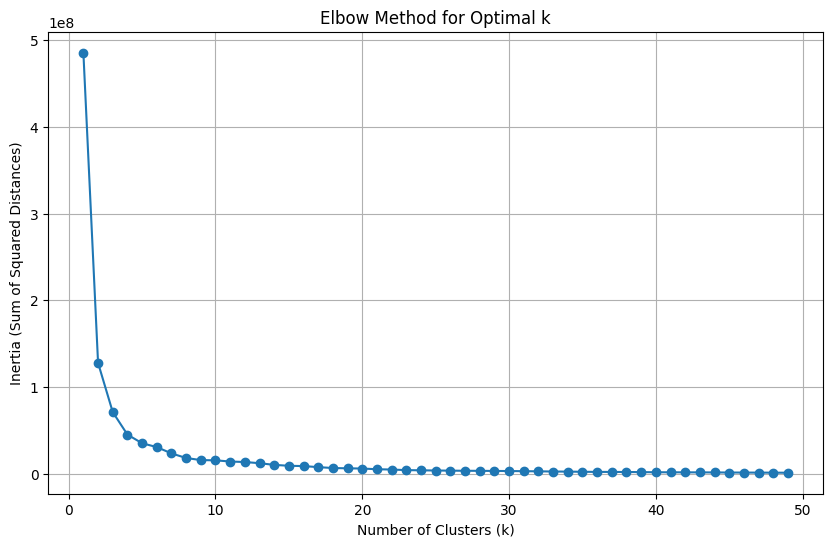

In [50]:
# Clustering based on geographical coordinates for challenge_set_updated

# Extract coordinates for adep and ades
adep_coords = challenge_set_updated[['Latitude_adep', 'Longitude_adep']].values
ades_coords = challenge_set_updated[['Latitude_ades', 'Longitude_ades']].values

# Combine all coordinates for clustering
combined_coords = np.vstack((adep_coords, ades_coords))

# Calculate inertia for each k value in the specified range
inertia = []
k_range = range(1, 50)  # Testing cluster sizes from 1 to 50

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(combined_coords)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()
        
# Automatically determining the optimal k using the "elbow" point
# Finding the point where the reduction in inertia slows down significantly
optimal_k = 1  # Default to 1 cluster if no elbow is detected
threshold_ratio = 0.01  # Define a threshold for identifying the elbow point

# Checking for the point where inertia reduction starts to slow down
for i in range(1, len(inertia) - 1):
    if (inertia[i - 1] - inertia[i]) > (inertia[i] - inertia[i + 1]) * threshold_ratio:
        optimal_k = i + 1
        break

In [51]:
# Apply K-means clustering on combined coordinates
kmeans_geo = KMeans(n_clusters=20, random_state=42)  
kmeans_geo.fit(combined_coords)

# Assign cluster labels back to adep and ades separately
adep_geo_labels = kmeans_geo.predict(adep_coords)
ades_geo_labels = kmeans_geo.predict(ades_coords)

# Map cluster labels to the original dataframe
challenge_set_updated['adep_geo_cluster'] = adep_geo_labels
challenge_set_updated['ades_geo_cluster'] = ades_geo_labels

In [52]:
# Clustering based on geographical coordinates for submission_set_updated

# Extract coordinates for adep and ades from submission_set_updated
adep_coords_submission = submission_set_updated[['Latitude_adep', 'Longitude_adep']].values
ades_coords_submission = submission_set_updated[['Latitude_ades', 'Longitude_ades']].values

# Assign cluster labels back to adep and ades separately for submission_set_updated
adep_geo_labels_submission = kmeans_geo.predict(adep_coords_submission)
ades_geo_labels_submission = kmeans_geo.predict(ades_coords_submission)

# Map cluster labels to the submission_set_updated dataframe
submission_set_updated['adep_geo_cluster'] = adep_geo_labels_submission
submission_set_updated['ades_geo_cluster'] = ades_geo_labels_submission

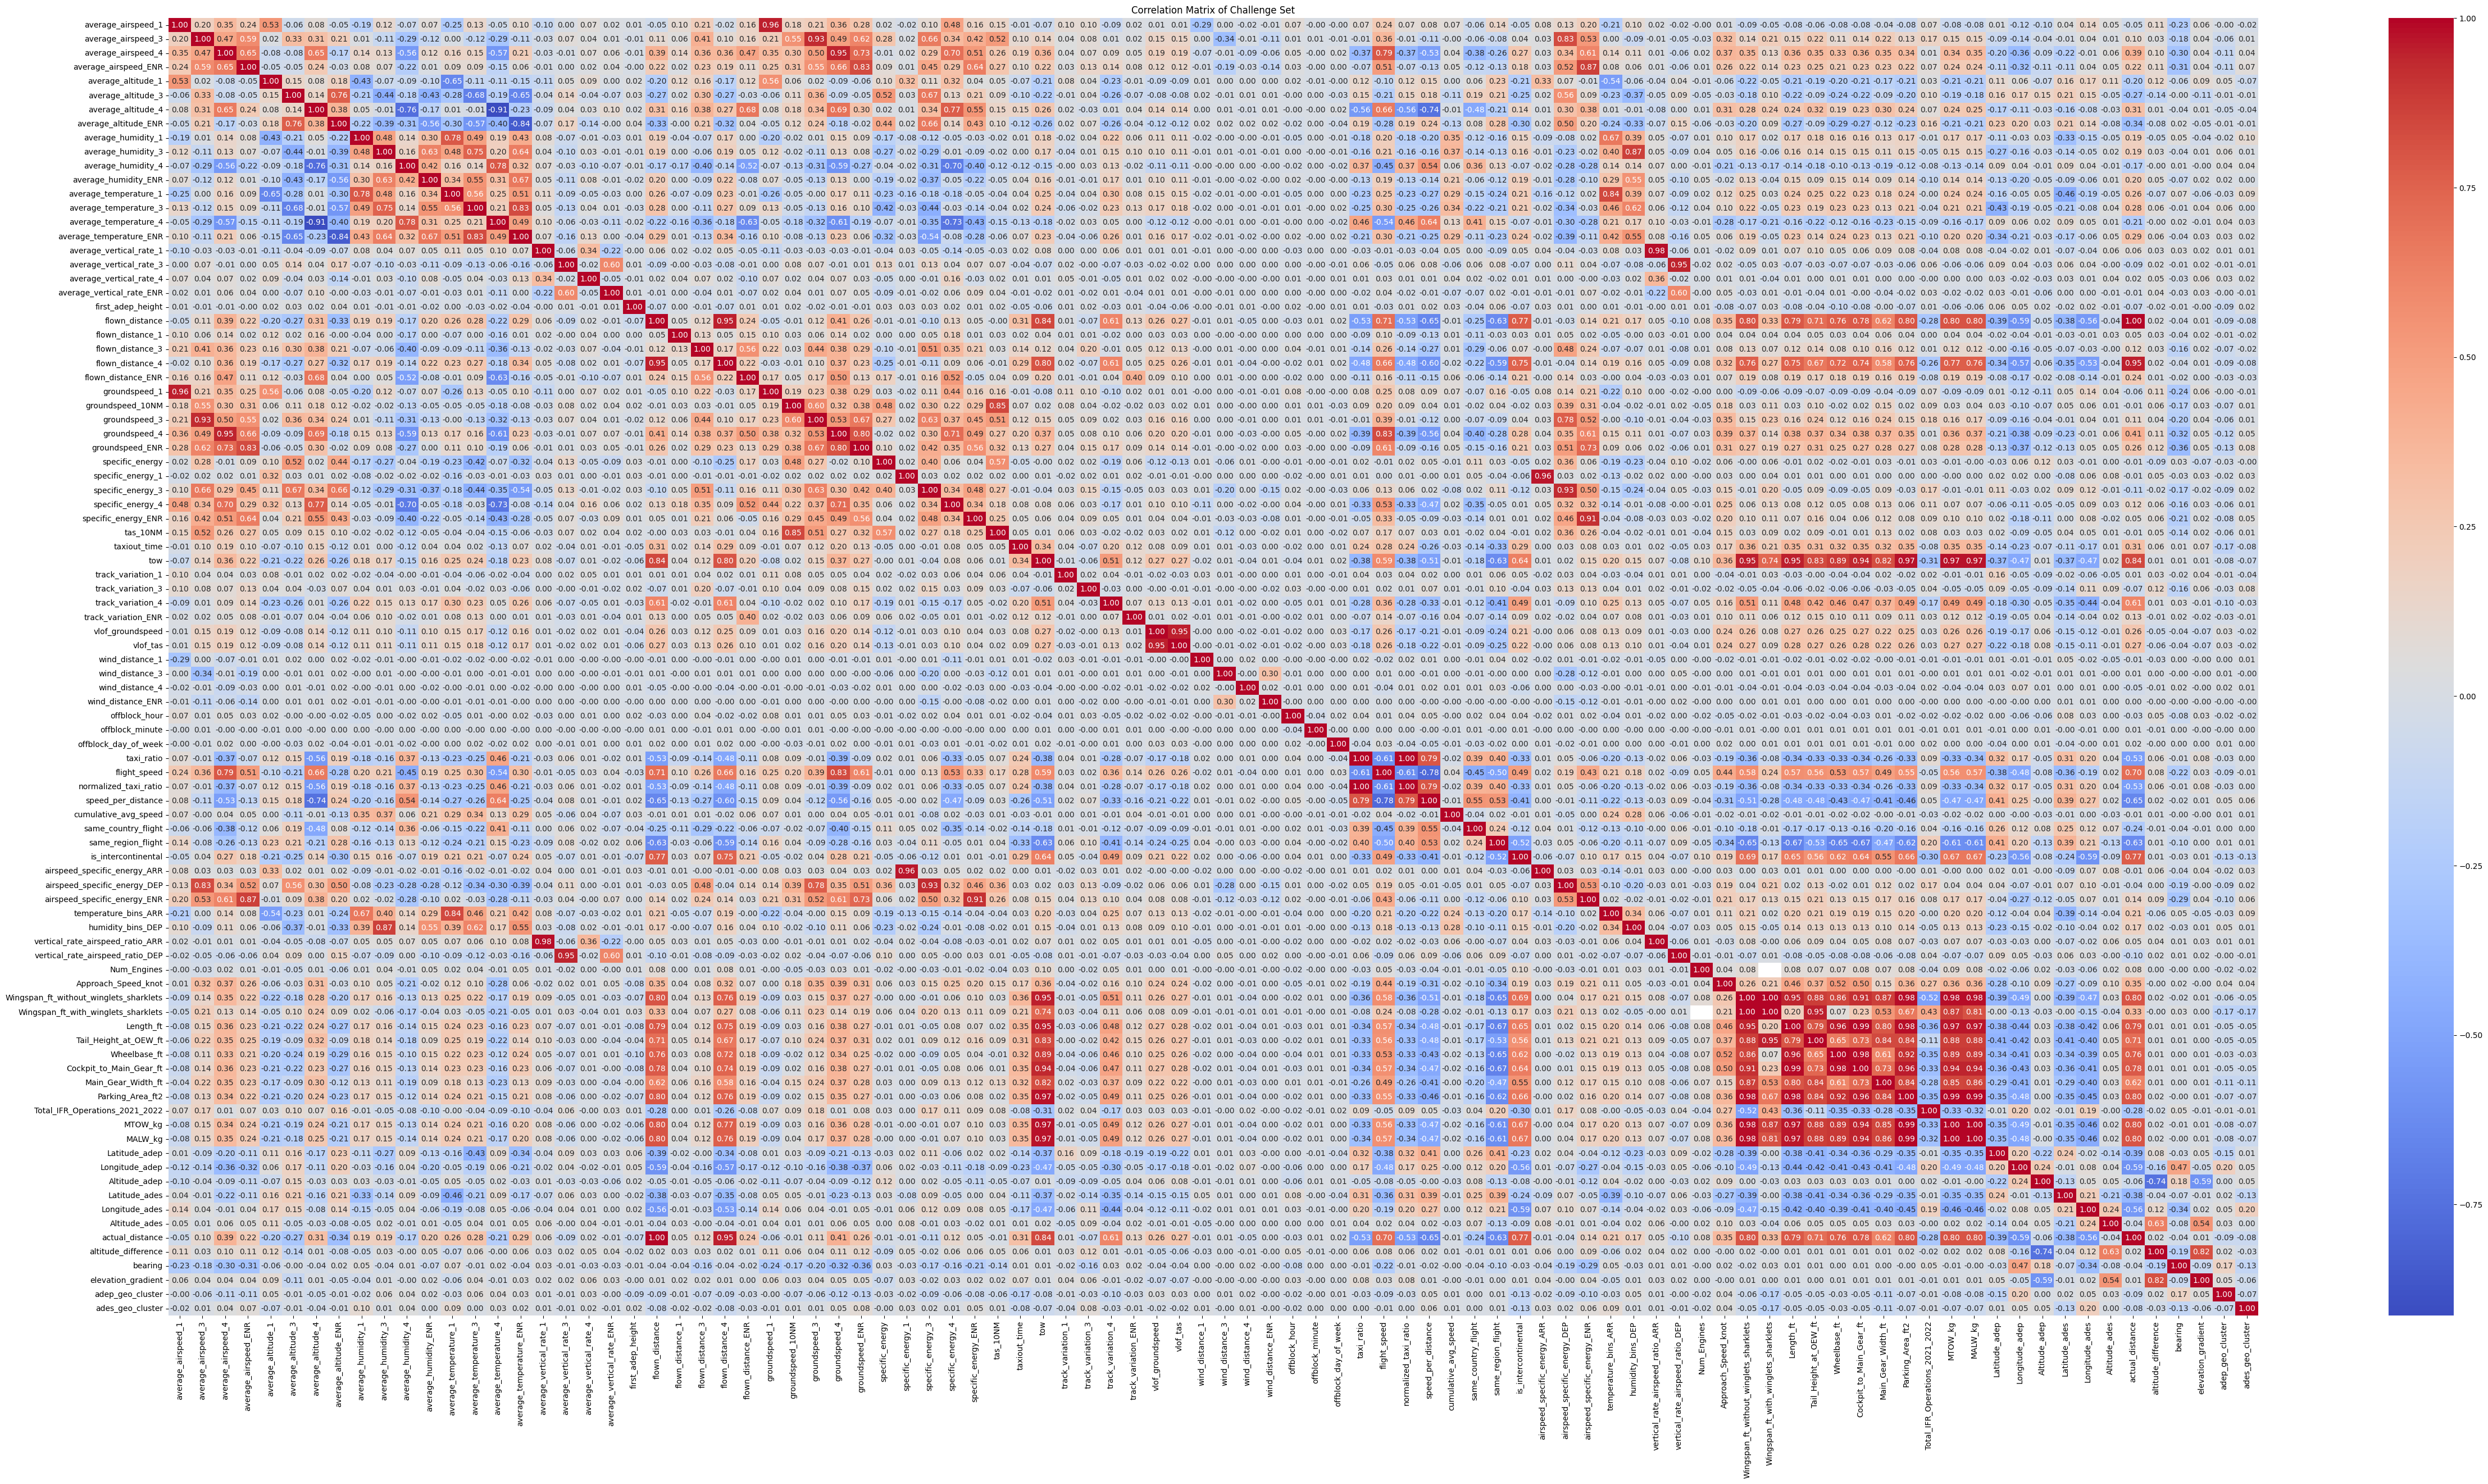

In [53]:
# Summary statistics of the challenge set
challenge_summary = challenge_set_updated.describe()

# Check for missing values
missing_values = challenge_set_updated.isnull().sum()

# Select only numerical columns
numerical_cols = challenge_set_updated.select_dtypes(include=['number'])

# Correlation matrix to check relationships between numerical features
correlation_matrix = numerical_cols.corr()

# Plotting the correlation matrix
plt.figure(figsize=(60, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Challenge Set')
plt.show()

In [54]:
list(challenge_set_updated.columns)

['adep',
 'ades',
 'aircraft_type',
 'airline',
 'average_airspeed_1',
 'average_airspeed_3',
 'average_airspeed_4',
 'average_airspeed_ENR',
 'average_altitude_1',
 'average_altitude_3',
 'average_altitude_4',
 'average_altitude_ENR',
 'average_humidity_1',
 'average_humidity_3',
 'average_humidity_4',
 'average_humidity_ENR',
 'average_temperature_1',
 'average_temperature_3',
 'average_temperature_4',
 'average_temperature_ENR',
 'average_vertical_rate_1',
 'average_vertical_rate_3',
 'average_vertical_rate_4',
 'average_vertical_rate_ENR',
 'date',
 'first_adep_height',
 'flown_distance',
 'flown_distance_1',
 'flown_distance_3',
 'flown_distance_4',
 'flown_distance_ENR',
 'groundspeed_1',
 'groundspeed_10NM',
 'groundspeed_3',
 'groundspeed_4',
 'groundspeed_ENR',
 'specific_energy',
 'specific_energy_1',
 'specific_energy_3',
 'specific_energy_4',
 'specific_energy_ENR',
 'tas_10NM',
 'taxiout_time',
 'tow',
 'track_variation_1',
 'track_variation_3',
 'track_variation_4',
 'tra

In [57]:
# Define the categorical columns you want to analyze
categorical_columns = [
    'aircraft_type', 'wtc', 'airline', 'offblock_hour', 'offblock_minute',
    'offblock_day_of_week', 'offblock_month', 'offblock_week_of_year',
    'offblock_season', 'arrival_hour', 'arrival_minute', 'is_offblock_weekend',
    'is_offblock_rush_hour', 'flight_duration_category', 'adep_region',
    'ades_region', 'same_country_flight', 'same_region_flight', 'flight_direction',
    'is_intercontinental', 'Physical_Class_Engine', 'Num_Engines',
    'Main_Gear_Config', 'FAA_Weight', 'adep_geo_cluster', 'ades_geo_cluster'
]

# Check if each column in the list exists in the dataframe, and keep only those that do
existing_columns = [col for col in categorical_columns if col in challenge_set_updated.columns]

# Calculate the number of unique values for each existing categorical column
unique_variations = challenge_set_updated[existing_columns].nunique()

# Display the number of variations for each categorical variable
print(unique_variations)


aircraft_type               30
wtc                          2
airline                     29
offblock_hour               24
offblock_minute             60
offblock_day_of_week         7
flight_duration_category     4
adep_region                  7
ades_region                  7
same_country_flight          2
same_region_flight           2
flight_direction             3
is_intercontinental          2
Physical_Class_Engine        2
Num_Engines                  2
Main_Gear_Config             5
FAA_Weight                   3
adep_geo_cluster            20
ades_geo_cluster            20
dtype: int64


In [60]:
# Function to rearrange the dataframe so that the target variable 'tow' is the last column
def rearrange_columns(df):
    # Moving 'tow' to the last position
    columns = [col for col in df.columns if col != 'tow'] + ['tow']
    df = df[columns]
    return df

# Function to check and remove columns that don't exist before encoding
def safe_get_dummies(df, columns, drop_first=True):
    existing_columns = [col for col in columns if col in df.columns]
    return pd.get_dummies(df, columns=existing_columns, drop_first=drop_first)

# Define your categorical_columns somewhere in the code
categorical_columns = [
    'offblock_month', 'offblock_week_of_year', 'offblock_season',
    'arrival_hour', 'arrival_minute', 'is_offblock_weekend', 'is_offblock_rush_hour',
    # Add other categorical columns as needed
]

# Check and remove non-existent columns
challenge_set_updated = safe_get_dummies(challenge_set_updated, categorical_columns)
submission_set_updated = safe_get_dummies(submission_set_updated, categorical_columns)

# Align and correct the column sets between training and test sets as before
missing_cols = set(challenge_set_updated.columns) - set(submission_set_updated.columns)
missing_cols_df = pd.DataFrame(0, index=submission_set_updated.index, columns=list(missing_cols))
submission_set_updated = pd.concat([submission_set_updated, missing_cols_df], axis=1)

extra_cols = set(submission_set_updated.columns) - set(challenge_set_updated.columns)
submission_set_updated.drop(columns=list(extra_cols), inplace=True)
submission_set_updated = submission_set_updated[challenge_set_updated.columns]

# Rearrange columns function as previously defined
challenge_set_updated = rearrange_columns(challenge_set_updated)
submission_set_updated = rearrange_columns(submission_set_updated)


In [61]:
challenge_set_updated.to_csv('./data/challenge_set_updated_v14.csv', index=False)
submission_set_updated.to_csv('./data/submission_set_updated_v14.csv', index=False)